## Mobile Network Monitoring using AI for Anomaly Detection
### Georgios Christodoulou
#### University of Nicosia
#### Nicosia, Cyprus

In [36]:
# Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path  

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# visualization
import matplotlib.pyplot as plt
import seaborn as sns 

# Algorithms
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from prophet import Prophet

# Model performance evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [2]:
def pullFilesbyPattern(pattern, filesNo):
    files = glob.glob(pattern)
    print(len(files))
    df = pd.DataFrame()
    fc =0
    for f in files:
        if fc >= filesNo:
            break    
        # Concat Instead of append
        df = pd.concat([df,pd.read_csv(f, low_memory=False)])
        fc += 1
        

    return df.reset_index(drop=True)

In [3]:
def DataCleaning(df,firstMetricLoc):
    #isinstance(df[m], numbers.Number),
    df = df.copy()
    print(df.shape)
    
    metrics_list = df.columns.tolist()[firstMetricLoc:]
    metrics_list_error = []
    for m in metrics_list:
        # check if column is object and can be converted to float
        try:
            if df[m].dtype == 'object':
                df[m] = df[m].str.replace(',', '')
                df[m] = df[m].astype('float64')
        except ValueError:
            metrics_list_error.append(m)
            pass # skip columns that cannot be converted to float64
            
        # replace missing values with 0
        df[m] = df[m].fillna(0)
        
    return df, metrics_list_error


## the the datatime index and group the data by hour
def getDatasetbySites(df,date_col, site_name_column,granularity,firstMetricColumn):
    
    sites = df[site_name_column].unique()
    metrics_list = df.columns.tolist()[firstMetricColumn:]
   
    # Resultant list of datasets
    dset_list = []
    for site in sites:
        #print(site)
        dset = df.loc[df[site_name_column]==site].copy()
        #print(dset[site_name_column].unique())
        #df = df.drop_duplicates()
        dset['datetime'] = pd.to_datetime(dset[date_col])
        dset = dset.set_index('datetime')
    
        # Group data by hour using groupby() with pd.Grouper()
        dset = dset.groupby([pd.Grouper(freq=granularity, level='datetime')])[metrics_list].mean()
        #print(dset.dtypes)
        # Resample data by hour using resample()
        #dset = dset.resample(granularity).mean()
        
        # add the SiteCode column
        dset['SiteCode'] = site
        
        dset_list.append(dset)
    
    # Concatenate all datasets
    full_dataset = pd.concat(dset_list, axis=0)
    return full_dataset

def storeData(df, filename):
    filepath = Path(filename)  
    filepath.parent.mkdir(parents=True, exist_ok=True)  
    df.to_csv(filepath) 

def pullData(filename,date_col):
    filepath = Path(filename)
    df = pd.read_csv(filepath) 
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col)
    return df

In [4]:
def remove_high_corr_features(df,threshold_in):
    # calculate the correlation matrix
    corr_matrix = df.corr()

    # select features with high correlation coefficients
    high_corr_features = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold_in:
                colname = corr_matrix.columns[i]
                high_corr_features.add(colname)
            
            
    # drop the highly correlated features from the dataset
    return df.drop(high_corr_features, axis=1)


def plot_corr_matrix(df):
    # calculate the correlation matrix
    corr_matrix = df.corr()

    # create a mask to ignore the diagonal elements of the correlation matrix
    mask = np.zeros_like(corr_matrix)
    mask[np.triu_indices_from(mask)] = True
    
    # plot the correlation matrix
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm')

# Normalized Values with StandardScaler or MinMaxScaler
# Use the VarianceThreshold feature_selection to remove all low-variance features.
def remove_low_variance_features(df,threshold_in):
    #print(.140 * (1 - .140))
    df  = df.copy()
    features = df.columns
    
    sel = VarianceThreshold(threshold=threshold_in) 
    x = sel.fit_transform(df)
    
    # Get the indices of the selected features
    selected_indices = sel.get_support(indices=True)
        
    # Get the names of the selected features
    selected_features = df.columns[selected_indices]
   
    #low_variance_features = intersection(features,selected_features)
    low_variance_features = set(features)-set(selected_features)
    
    #print('{} - {}'.format(len(features),len(selected_features)))
    #print(len(low_variance_features))
    
    # drop the highly correlated features from the dataset
    return df.drop(low_variance_features, axis=1)


def fillNa(df,rolling_window):
    df = df.copy()
   
    # Show the rows with NAN values
    nan_rows = df[df.isnull().any(axis=1)]
    
    while(nan_rows.shape[0] > 0):
        # Use transform to fill null values with the rolling mean of the corresponding group
        df = df.transform(lambda x: x.fillna(x.rolling(window=rolling_window, min_periods=1).mean()))
        nan_rows = df[df.isnull().any(axis=1)]
           
        # Fill null values with zeros
        #dset = dset.fillna(-999)
        # dset = dset.dropna()
    return df
 

def normalizedValues(df,scaler):
    df = df.copy()
    #scaler = StandardScaler()
    #scaler = MinMaxScaler((0, 1))
    # Min Max Scaler
    ts = scaler.fit_transform(df)

    lables = df.columns
    for i in range(len(lables)):
        df[lables[i]] = ts.T[i]
    
    return df

def rollingAvg(df,rolling_window):
    df = df.copy()
    df = df.rolling(window=rolling_window).mean().fillna(method='bfill').fillna(method='ffill')

    #df = df.transform(lambda x: x.fillna(x.rolling(window=rolling_window, min_periods=1).mean()))
    #df = df.dropna()
    return df  

# Check for missing values
def getMissingValues(df):
    columns_missing_values = {}
    for c in df.columns:
        msv = df[df[c].isna()| df[c].eq(' ')].shape[0]
        if msv > 0:
            columns_missing_values[c] = (msv,msv/df.shape[0]*100)
    return columns_missing_values

In [5]:
def plotMultipleMetrics(df, size_x, size_y):
    metrics = df.columns
    
    fig, axs = plt.subplots(size_y,size_x,figsize=(25,25))
    
    fig.suptitle('Series')
    for i in range(size_y):
        for j in range(size_x):
            if i*4+j+1>len(metrics): # pass the others that we can't fill
                continue
            axs[i, j].plot(df.index,df[metrics[i*4+j]]) #time_series_data[i*4+j].values)
            axs[i, j].set_title(metrics[i*4+j])
    plt.show()

In [6]:
### This is not need to run every time as we have aggregate the data and store in new path
ztedf = pullFilesbyPattern('..\ZTE_NBI\CallAccess_FDD_[0-9]*.csv', 50)
ztedf.head()

48


Begin Time             End Time Granularity  SubnetWork ID  \
0  2023-01-31 00:00:00  2023-01-31 00:15:00  15 minutes              1   
1  2023-01-31 00:00:00  2023-01-31 00:15:00  15 minutes              1   
2  2023-01-31 00:00:00  2023-01-31 00:15:00  15 minutes              1   
3  2023-01-31 00:00:00  2023-01-31 00:15:00  15 minutes              1   
4  2023-01-31 00:00:00  2023-01-31 00:15:00  15 minutes              1   

  SubnetWork Name  ManagedElement ID Managed Element    eNodeB ID eNodeB Name  \
0            1(1)               5003    PAF003(5003)  280-20_5003      PAF003   
1            1(1)               5003    PAF003(5003)  280-20_5003      PAF003   
2            1(1)               5003    PAF003(5003)  280-20_5003      PAF003   
3            1(1)               5003    PAF003(5003)  280-20_5003      PAF003   
4            1(1)               5003    PAF003(5003)  280-20_5003      PAF003   

   E-UTRAN FDD Cell ID  ...  \
0                   21  ...   
1                   22  ...   
2                   23  ...   
3                   31  ...   
4                   32  ...   

  Number of Cell DRB Admission Failure due to Not Enough CPU Resource(times)  \
0                                                  0                           
1                                                  0                           
2                                                  0                           
3                                                  0                           
4                                                  0                           

   Number of Cell DRB Admission Failure due to PHY Resource Allocated Failure(times)  \
0                                                  0                                   
1                                                  0                                   
2                                                  0                                   
3                                                  0                                   
4                                                  0                                   

   Number of Cell Admission Failure due to Service Cell Other Parameters Modification(times)  \
0                                                  0                                           
1                                                  0                                           
2                                                  0                                           
3                                                  0                                           
4                                                  0                                           

  Number of Cell Admission Failure due to Target PLMN selected Failure(times)  \
0                                                  0                            
1                                                  0                            
2                                                  0                            
3                                                  0                            
4                                                  0                            

  Number of Cell Admission Failure due to RRC Connection Number License Prohibit(times)  \
0                                                  0                                      
1                                                  0                                      
2                                                  0                                      
3                                                  0                                      
4                                                  0                                      

   Number of Cell Admission Failure due to E-RAB Number License Prohibit(times)  \
0                                                  0                              
1                                                  0                              
2                      

In [7]:
clean_ds, invalid_columns = DataCleaning(ztedf,14)

(500820, 195)


In [8]:
dsbysite = getDatasetbySites(clean_ds,'Begin Time','eNodeB Name','H',14)
storeData(dsbysite,'..\AggregatedData\ZTE_CallAccess_FDD.csv')
#getMissingValues(dsbysite)

In [6]:
dsbysite = pullData('..\AggregatedData\ZTE_CallAccess_FDD.csv','datetime')
dsbysite.head(5)

Number of Successful Mt-Access RRC Establishment(times)  \
datetime                                                                       
2023-01-31 00:00:00                                                0.0         
2023-01-31 01:00:00                                                0.0         
2023-01-31 02:00:00                                                0.0         
2023-01-31 03:00:00                                                0.0         
2023-01-31 04:00:00                                                0.0         

                     Number of Mo-Data RRC Establishment Failure due to Timeout(times)  \
datetime                                                                                 
2023-01-31 00:00:00                                           0.041667                   
2023-01-31 01:00:00                                           0.000000                   
2023-01-31 02:00:00                                           0.000000                   
2023-01-31 03:00:00                                           0.000000                   
2023-01-31 04:00:00                                           0.000000                   

                     Number of Mo-Signalling RRC Establishment Failure due to ENB Admission Failure(times)  \
datetime                                                                                                     
2023-01-31 00:00:00                                                0.0                                       
2023-01-31 01:00:00                                                0.0                                       
2023-01-31 02:00:00                                                0.0                                       
2023-01-31 03:00:00                                                0.0                                       
2023-01-31 04:00:00                                                0.0                                       

                     Number of Mo-Signalling RRC Establishment Failure due to Other Reason(times)  \
datetime                                                                                            
2023-01-31 00:00:00                                                0.0                              
2023-01-31 01:00:00                                                0.0                              
2023-01-31 02:00:00                                                0.0                              
2023-01-31 03:00:00                                                0.0                              
2023-01-31 04:00:00                                                0.0                              

                     Number of mo-VoiceCall RRC Establishment Failure due to Timeout(times)  \
datetime                                                                                      
2023-01-31 00:00:00                                                0.0                        
2023-01-31 01:00:00                                                0.0                        
2023-01-31 02:00:00                                                0.0                        
2023-01-31 03:00:00                                                0.0                        
2023-01-31 04:00:00                                                0.0                        

                     Number of mo-VoiceCall RRC Establishment Failure due to Other Reason(times)  \
datetime                                                                                           
2023-01-31 00:00:00                                                0.0                             
2023-01-31 01:00:00                                                0.0                             
2023-01-31 02:00:00                                                0.0                             
2023-01-31 03:00:00                                                0.0                             
2023-01-31 04:00:00                                                0.0              

In [7]:
dsbysitetypes = pd.DataFrame(dsbysite.dtypes, columns=['dtypes'])
dsbysitetypes.index.name= 'Column'
storeData(dsbysitetypes,'..\AggregatedData\ZTE_CallAccess_FDD_dtypes.csv')

## Find Sites Incidents related and update the data set with such information
- PAF024	2023-01-03 03:13:00.0000000
- PAF024	2023-02-01 06:16:00.0000000
- LIM090	2023-02-05 17:53:00.0000000
- LIM003	2023-03-17 12:33:00.0000000
- PAF031	2023-03-29 08:37:00.0000000

In [8]:
#incidents = [('2023-01-03 03:13:00','PAF024',1),
#            ('2023-02-01 06:16:00','PAF024',1),
#            ('2023-02-05 17:53:00','LIM090',1),
#            ('2023-03-17 12:33:00','LIM003',1),
#            ('2023-03-29 08:37:00','PAF031',1)]
# Convert the list of tuples into a pandas dataframe
col = ['datetime', 'SiteCode','incident']
#df_incidents = pd.DataFrame(incidents, columns=col)

df_incidents = pd.read_csv('..\AggregatedData\RANSitesIncidents.csv')
df_incidents['datetime'] = pd.to_datetime(df_incidents['startdatetime'], format='%d/%m/%Y %H:%M:%S').dt.floor("H")
df_incidents['incident'] = 1
df_incidents = df_incidents[col]
df_incidents = df_incidents.drop_duplicates()

dsbysite = pd.merge(dsbysite, df_incidents, on=['datetime','SiteCode'], how='left')
dsbysite['incident'] = dsbysite['incident'].notnull()
dsbysite.set_index('datetime', inplace=True)
dsbysite.loc[dsbysite['incident']==True]

Number of Successful Mt-Access RRC Establishment(times)  \
datetime                                                                       
2023-02-01 06:00:00                                                0.0         
2023-03-17 12:00:00                                                0.0         
2023-02-05 17:00:00                                                0.0         

                     Number of Mo-Data RRC Establishment Failure due to Timeout(times)  \
datetime                                                                                 
2023-02-01 06:00:00                                           0.000000                   
2023-03-17 12:00:00                                           0.166667                   
2023-02-05 17:00:00                                           0.000000                   

                     Number of Mo-Signalling RRC Establishment Failure due to ENB Admission Failure(times)  \
datetime                                                                                                     
2023-02-01 06:00:00                                                0.0                                       
2023-03-17 12:00:00                                                0.0                                       
2023-02-05 17:00:00                                                0.0                                       

                     Number of Mo-Signalling RRC Establishment Failure due to Other Reason(times)  \
datetime                                                                                            
2023-02-01 06:00:00                                           0.000000                              
2023-03-17 12:00:00                                           0.041667                              
2023-02-05 17:00:00                                           0.000000                              

                     Number of mo-VoiceCall RRC Establishment Failure due to Timeout(times)  \
datetime                                                                                      
2023-02-01 06:00:00                                                0.0                        
2023-03-17 12:00:00                                                0.0                        
2023-02-05 17:00:00                                                0.0                        

                     Number of mo-VoiceCall RRC Establishment Failure due to Other Reason(times)  \
datetime                                                                                           
2023-02-01 06:00:00                                                0.0                             
2023-03-17 12:00:00                                                0.0                             
2023-02-05 17:00:00                                                0.0                             

                     Number of mo-VoiceCall RRC Establishment Failure due to ENB Admission Failure(times)  \
datetime                                                                                                    
2023-02-01 06:00:00                                                0.0                                      
2023-03-17 12:00:00                                                0.0                                      
2023-02-05 17:00:00                                                0.0                                      

                     Number of Mt-Access RRC Establishment Failure due to Timeout(times)  \
datetime                                                                                   
2023-02-01 06:00:00                                                0.0                     
2023-03-17 12:00:00                                                0.0                     
2023-02-05 17:00:00                                                0.0                     

                     Number of Mo-Signalling RRC Establishment Failure due to Timeout(times)  \
datetime                        

## Filling Missing Values
#### Use Rolling Mean and experimented with the window 6, 12, 24 Hours

<Axes: xlabel='datetime'>

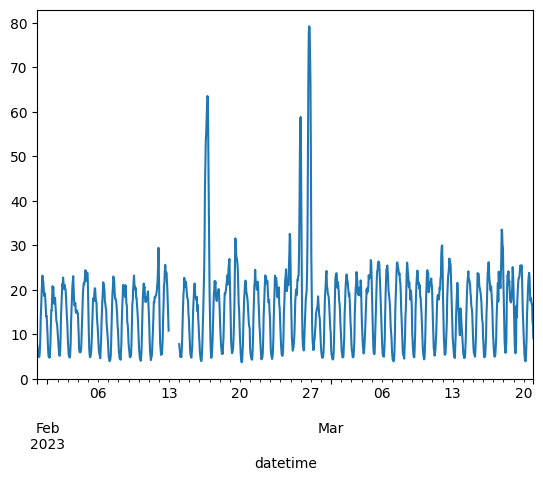

In [9]:
#### without Filling NA
site_df = dsbysite.loc[dsbysite['SiteCode'] == 'LIM003'].copy()
site_df = site_df.drop('SiteCode', axis=1)
#site_df[site_df.isnull().any(axis=1)].index
#.groupby([pd.Grouper(freq='D', level='datetime')]).mean()
site_df['Maximum Number of RRC Connection User(unit)'].plot()

0

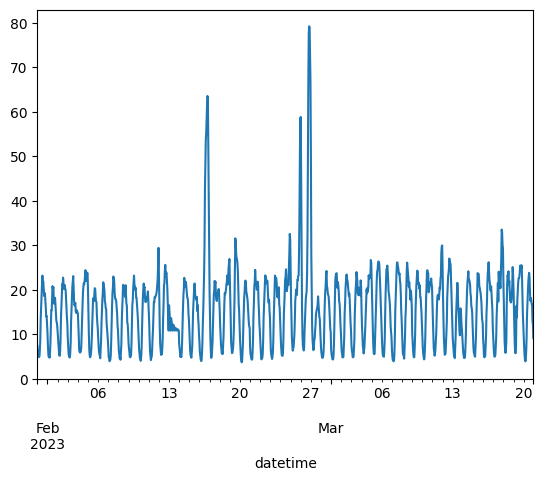

In [10]:
#### without Filling NA
site_df = dsbysite.loc[dsbysite['SiteCode'] == 'LIM003'].copy()
site_df = site_df.drop('SiteCode', axis=1)
site_df = fillNa(site_df,6)
#site_df = rollingAvg(site_df,24)

#site_df[site_df.isnull().any(axis=1)].index
#.groupby([pd.Grouper(freq='D', level='datetime')]).mean()
site_df['Maximum Number of RRC Connection User(unit)'].plot()
#site_df = site_df.shift(5, freq='D')
#site_df['Maximum Number of RRC Connection User(unit)'].plot()

# Show the rows with NAN values
nan_rows = site_df[site_df.isnull().any(axis=1)]
nan_rows.shape[0]

### Find the metrics that indicates network failures and separate them
We compute the mean value of them per time slot

kpis_metrics:97, failure_metrics: 84 = 14+70


<Axes: xlabel='datetime'>

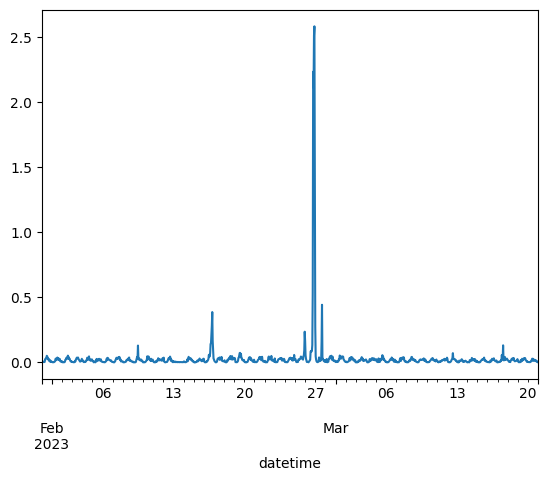

In [11]:
import re

def find_values(array, pattern):
    matching_values = []
    not_matching_values = []

    for item in array:
        if isinstance(item, str) and re.search(pattern, item):
            matching_values.append(item)
        else:
            not_matching_values.append(item)

    return matching_values, not_matching_values

# Example
pattern_fl_times = r"(Number of)(.)*(Failure)(.)*\(unit\)"
pattern_fl_unit = r"(Number of)(.)*(Failure)(.)*\(times\)"
pattern_fl = r"(Number of)(.)*(Failure)(.)*"

failure_metrics, kpis_metrics =find_values(site_df.columns,pattern_fl)
failure_metrics_unit, failure_metrics_times =find_values(failure_metrics,pattern_fl_times)
kpis_metrics.remove('incident')

print("kpis_metrics:{}, failure_metrics: {} = {}+{}".format(len(kpis_metrics), len(failure_metrics), len(failure_metrics_unit), len(failure_metrics_times)))


#plotMultipleMetrics(site_df[failure_metrics_times],2,5)
failureInd = site_df[failure_metrics_times].copy()
failureInd['Mean'] = failureInd.mean(axis=1)
failureInd['Mean'].plot()

<Axes: xlabel='datetime'>

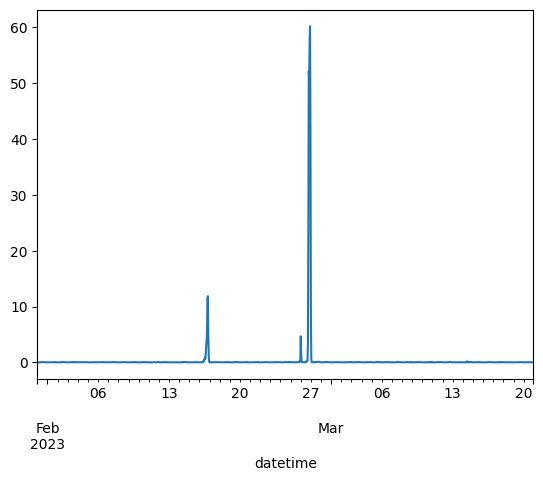

In [12]:
failureInd = site_df[failure_metrics_unit].copy()
failureInd['Mean'] = failureInd.mean(axis=1)
failureInd['Mean'].plot()

### Insect the the outliers of this values, 
ideal we can use the outliers as indication of system abnormality

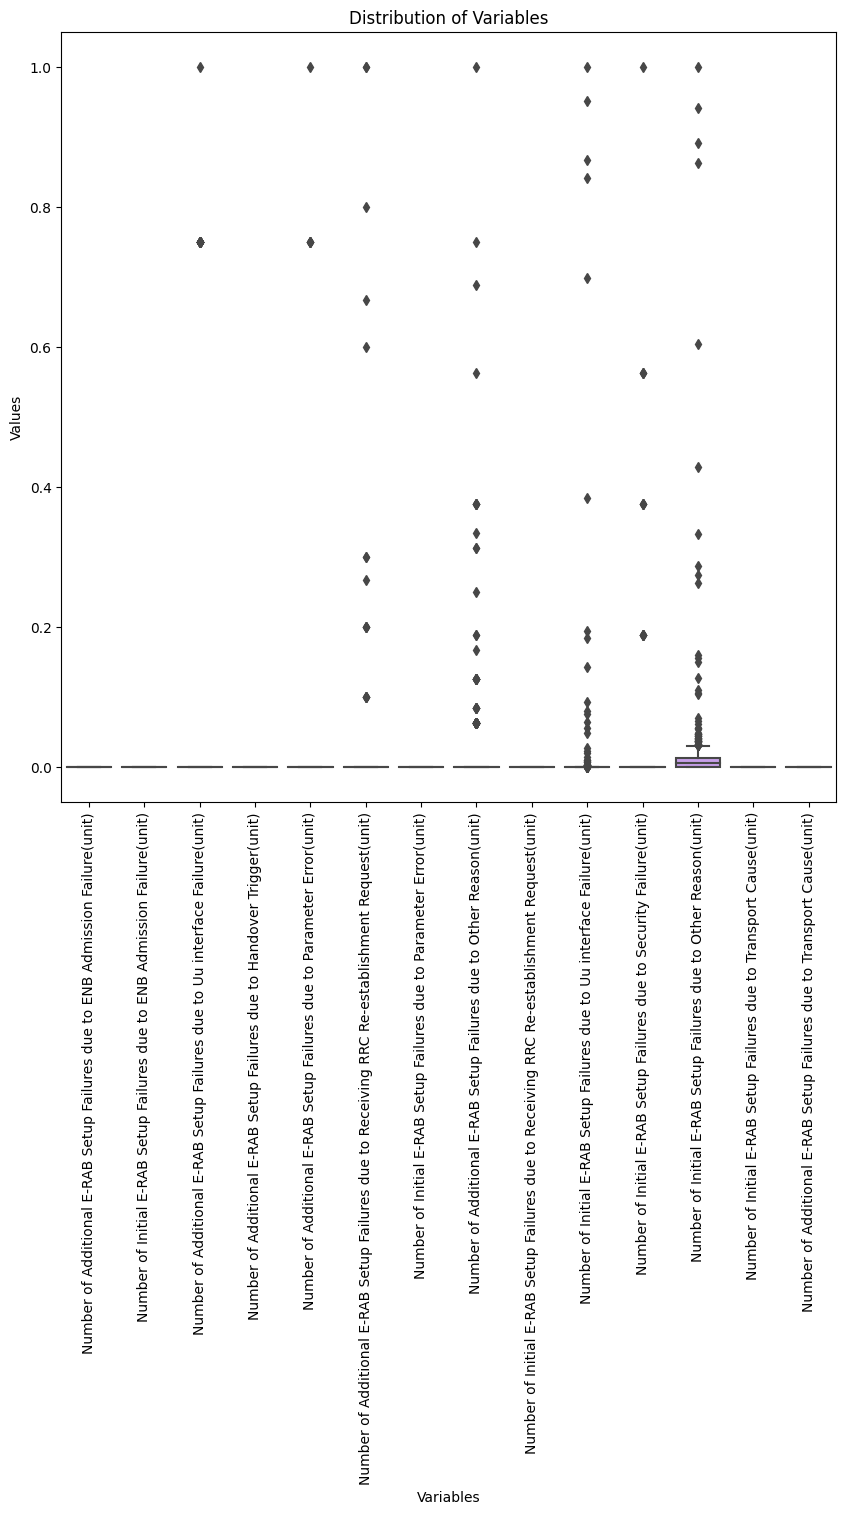

In [13]:
# Box plot
plt_df = normalizedValues(site_df[failure_metrics_unit],MinMaxScaler((0, 1)))

plt.figure(figsize=(10,10))
sns.boxplot(data=plt_df)
plt.xticks(rotation=90)
plt.xlabel('Variables')
plt.ylabel('Values')
plt.title('Distribution of Variables')
plt.show()

## Data Observation
Apply features selections and observe the distribution of values

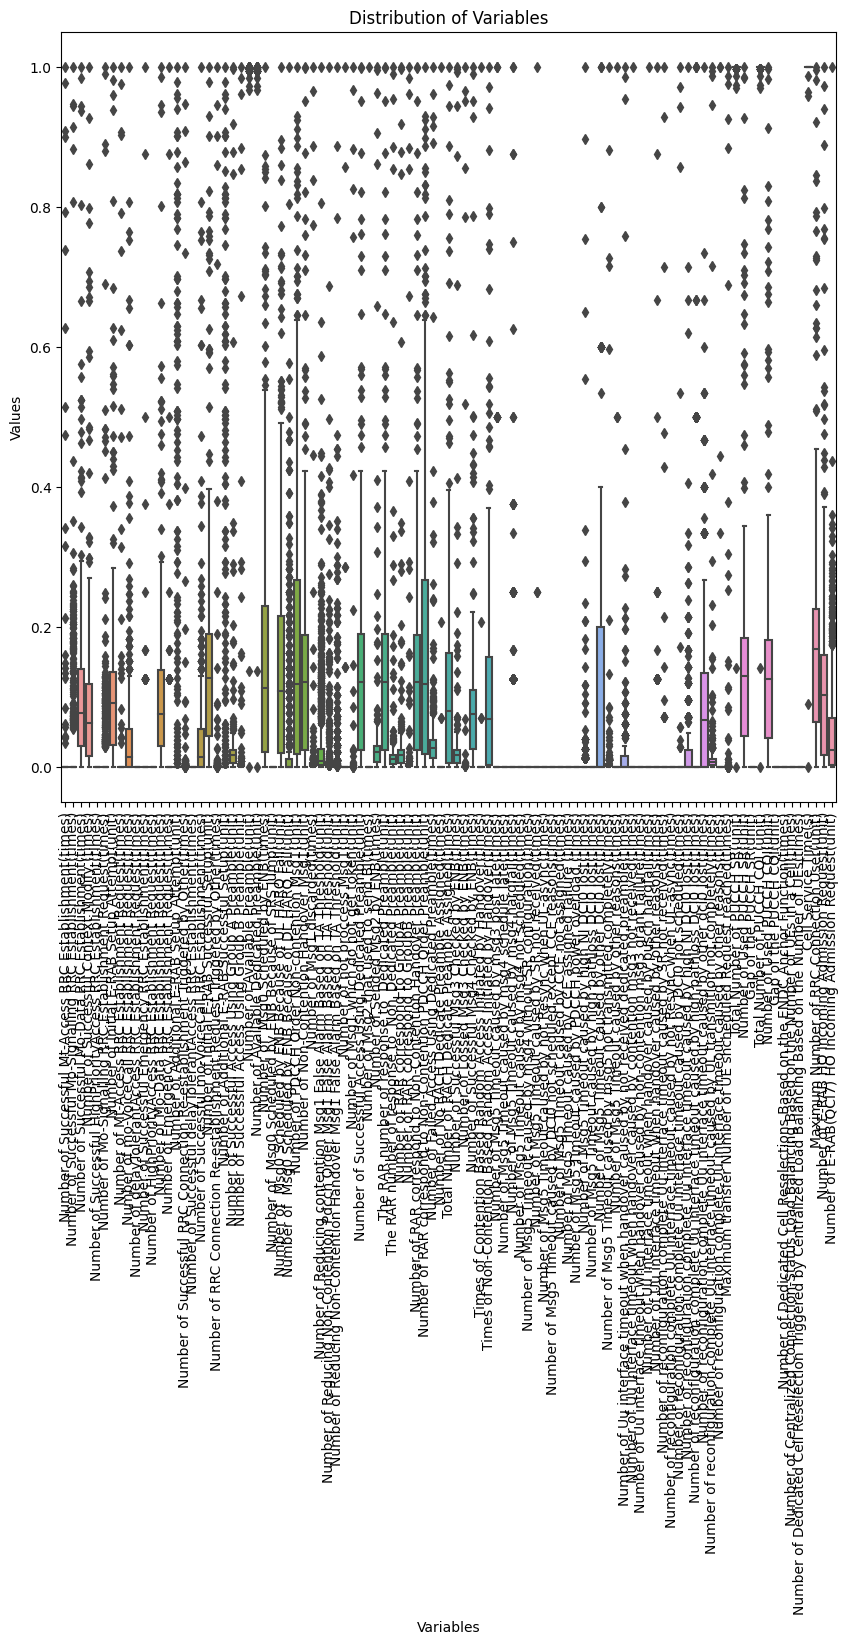

In [14]:
# Box plot
plt_df = normalizedValues(site_df[kpis_metrics],MinMaxScaler((0, 1)))

plt.figure(figsize=(10,10))
sns.boxplot(data=plt_df)
plt.xticks(rotation=90)
plt.xlabel('Variables')
plt.ylabel('Values')
plt.title('Distribution of Variables')
plt.show()

### VarianceThreshold and Correlation-based 
is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.
As an example, suppose that we have a dataset with boolean features, and we want to remove all features that are either one or zero (on or off) in more than 80% of the samples. Boolean features are Bernoulli random variables, and the variance of such variables is given by

(1176, 54)
(1176, 37)


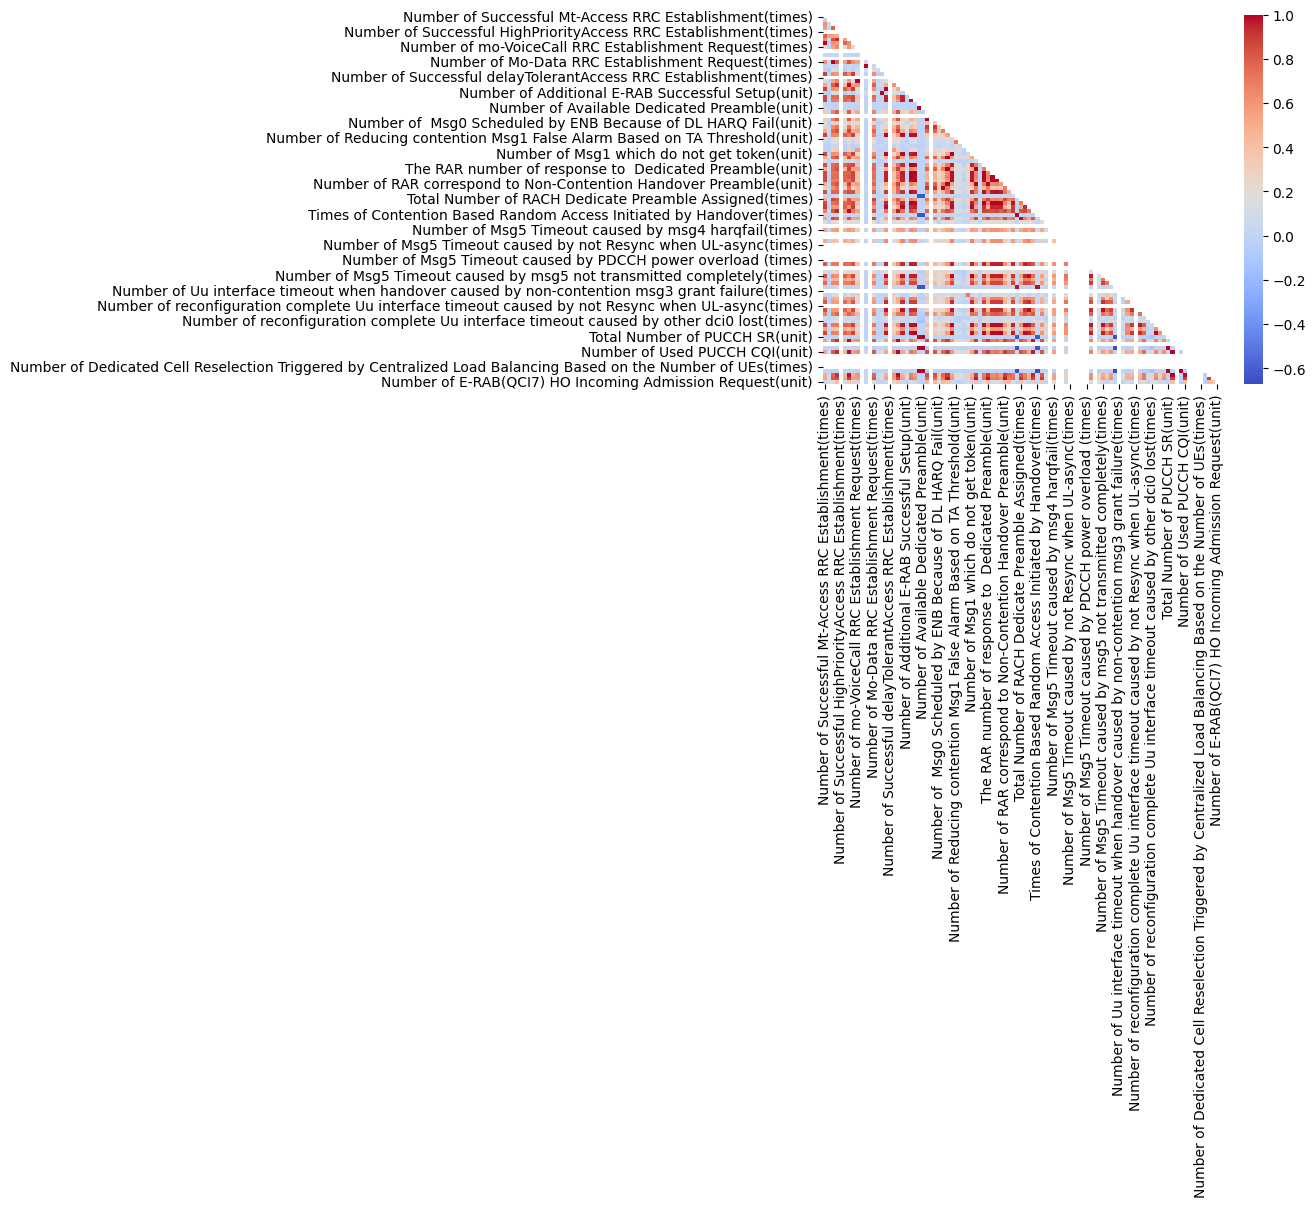

In [15]:
site_df = dsbysite.loc[dsbysite['SiteCode'] == 'LIM003'].copy()
site_df = site_df.drop('SiteCode', axis=1)
site_df = site_df[kpis_metrics]
site_df = fillNa(site_df,24)

plot_corr_matrix(site_df)

site_df = remove_low_variance_features(site_df,0.05)
print(site_df.shape)
site_df = remove_high_corr_features(site_df,0.999)
print(site_df.shape)
#site_df = normalizedValues(site_df,StandardScaler()) # MinMaxScaler((0, 1)) )
#getMissingValues(site_df)

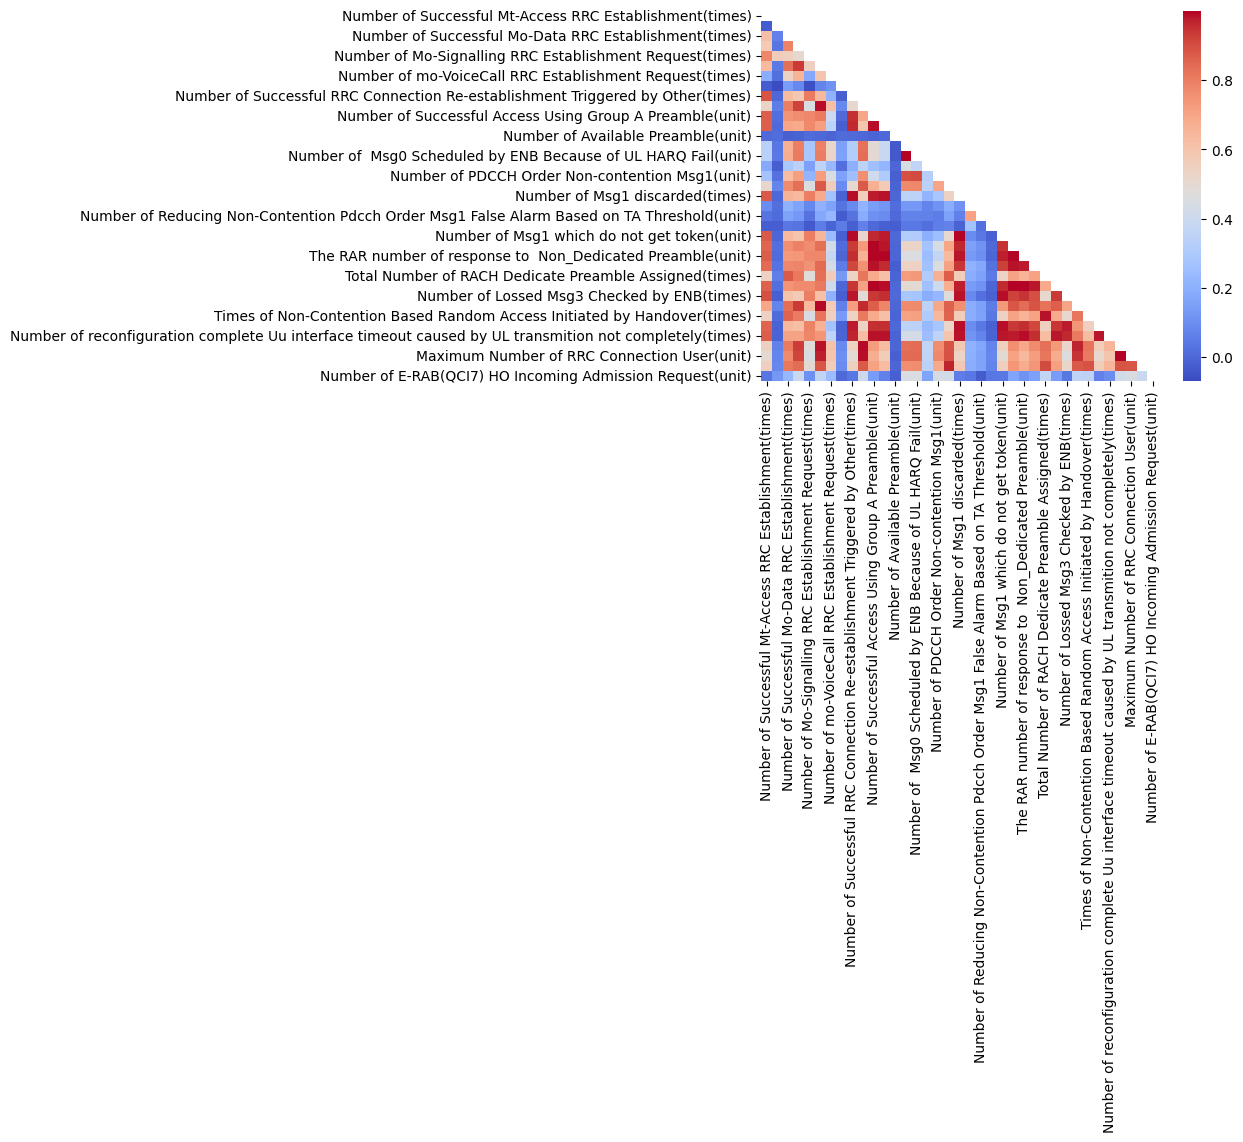

In [16]:
## After 
plot_corr_matrix(site_df)

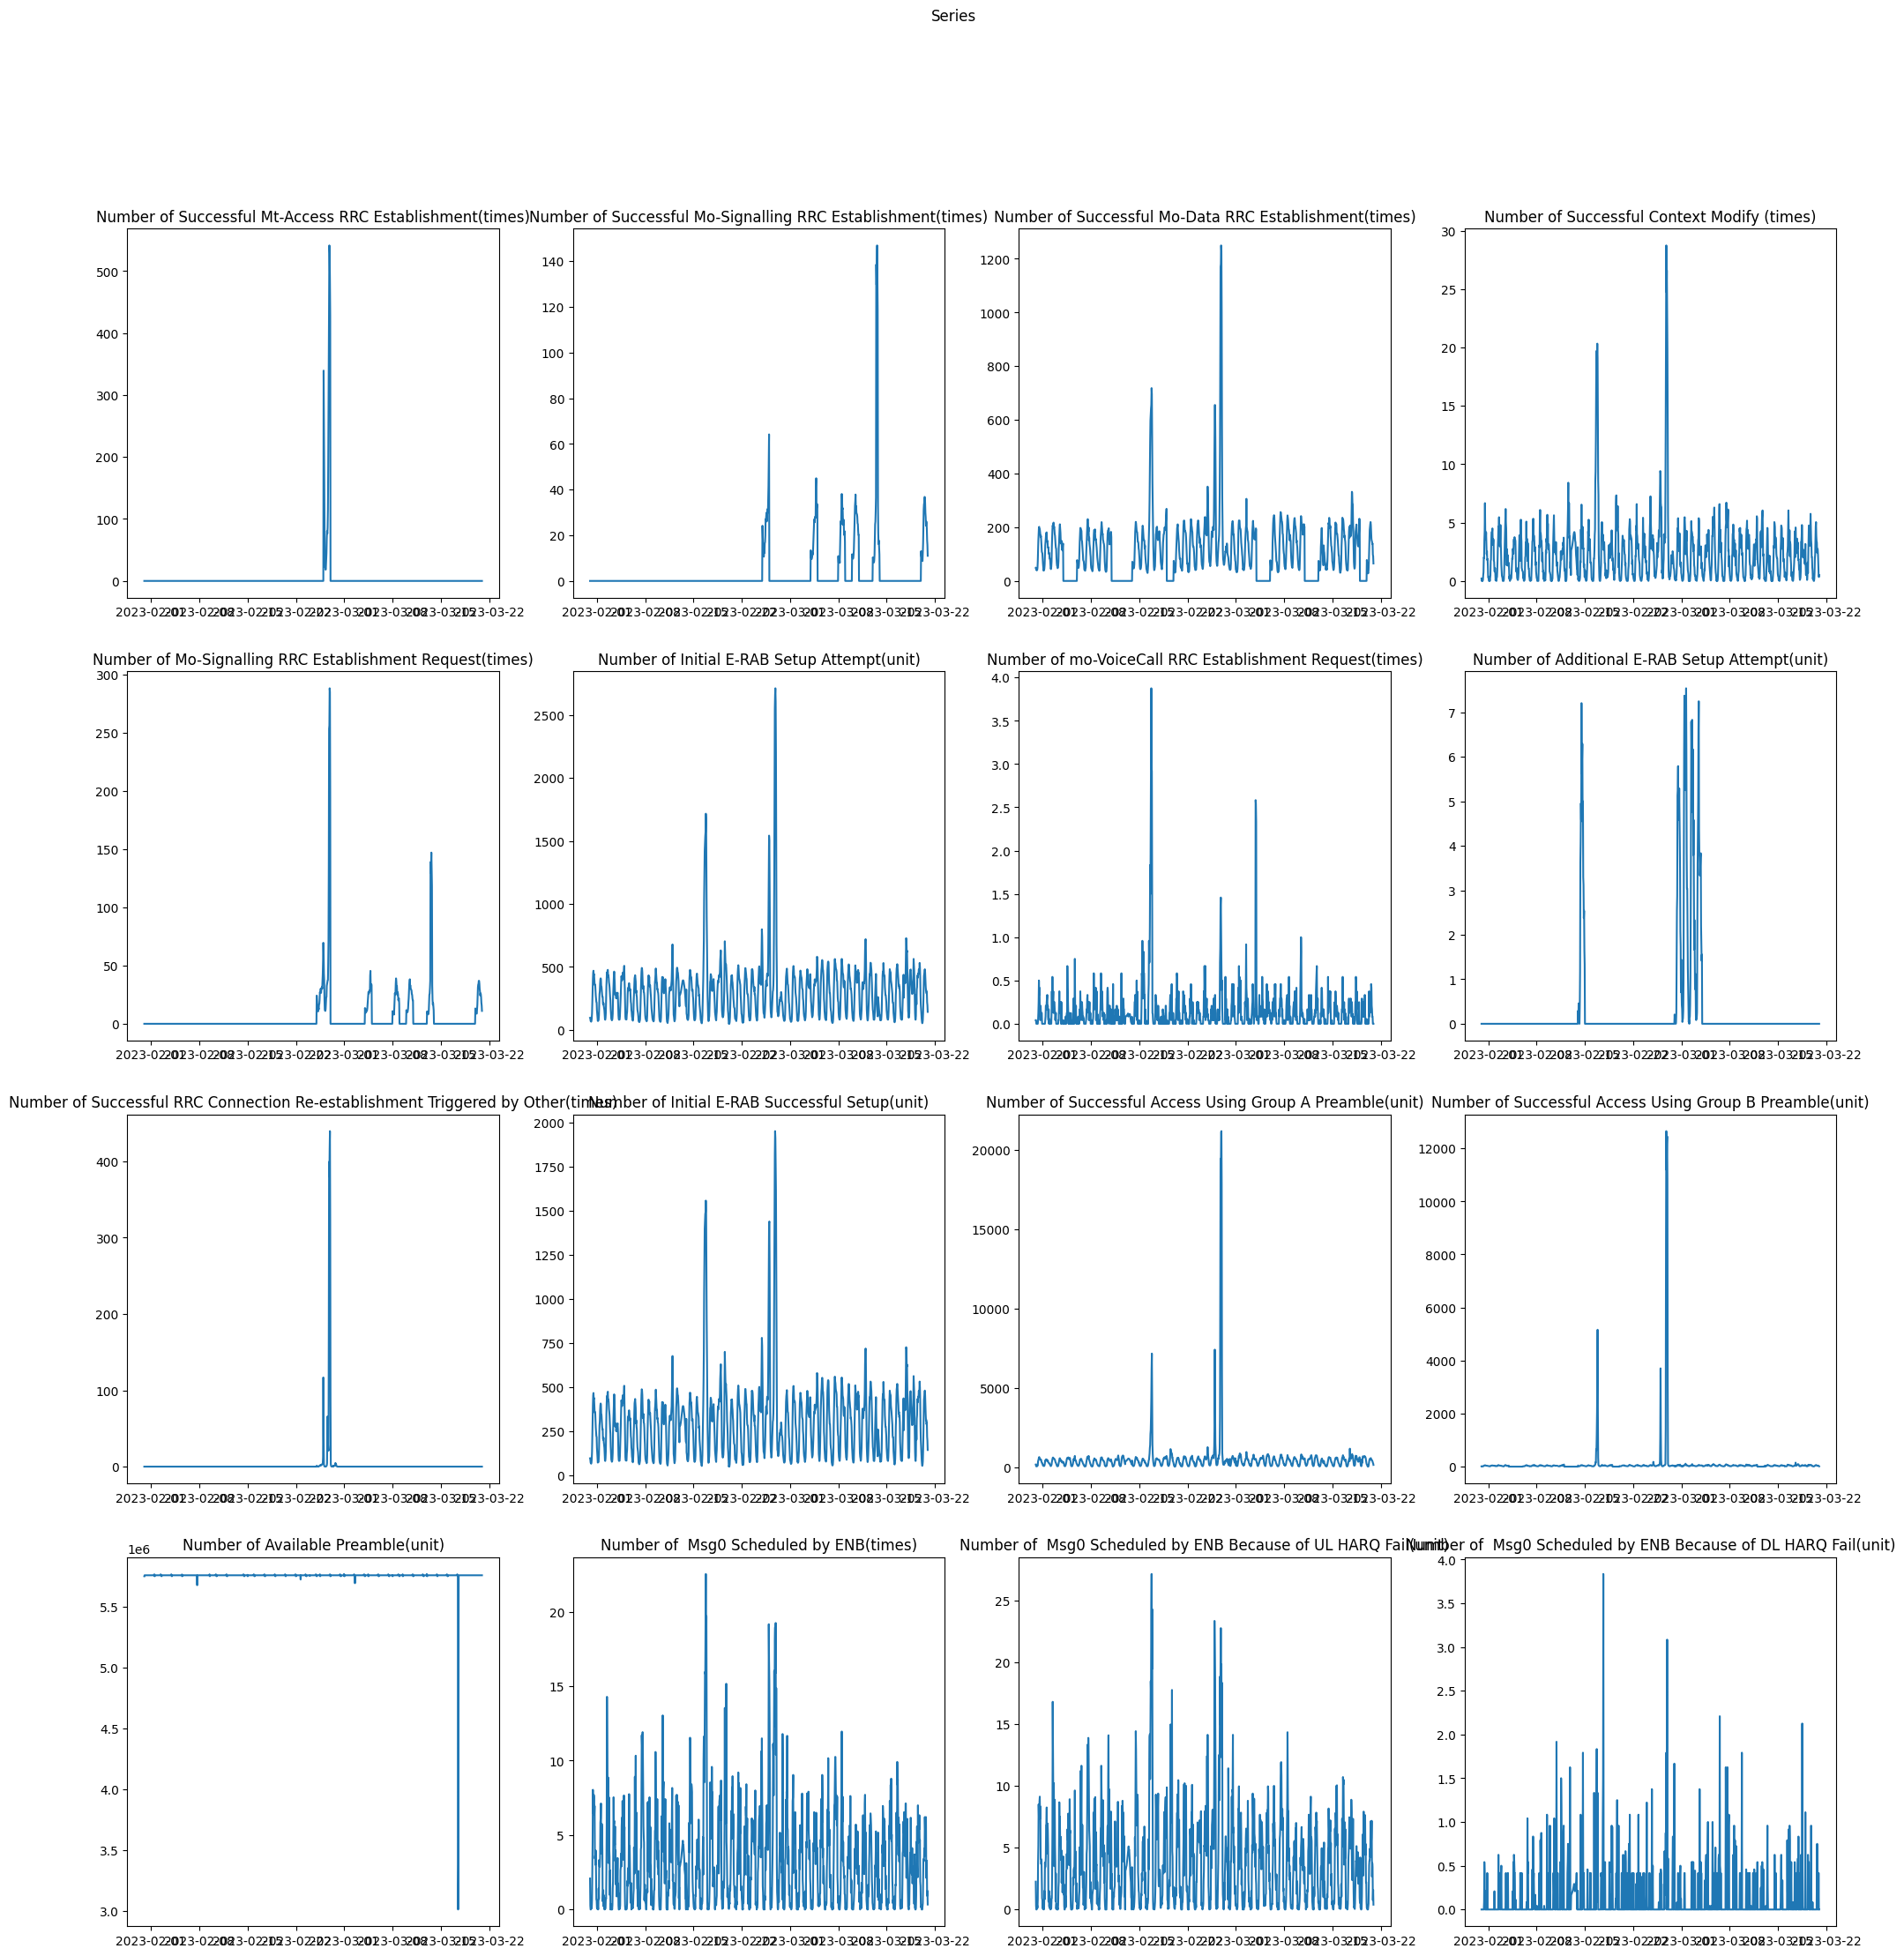

In [17]:
plotMultipleMetrics(site_df,4,4)

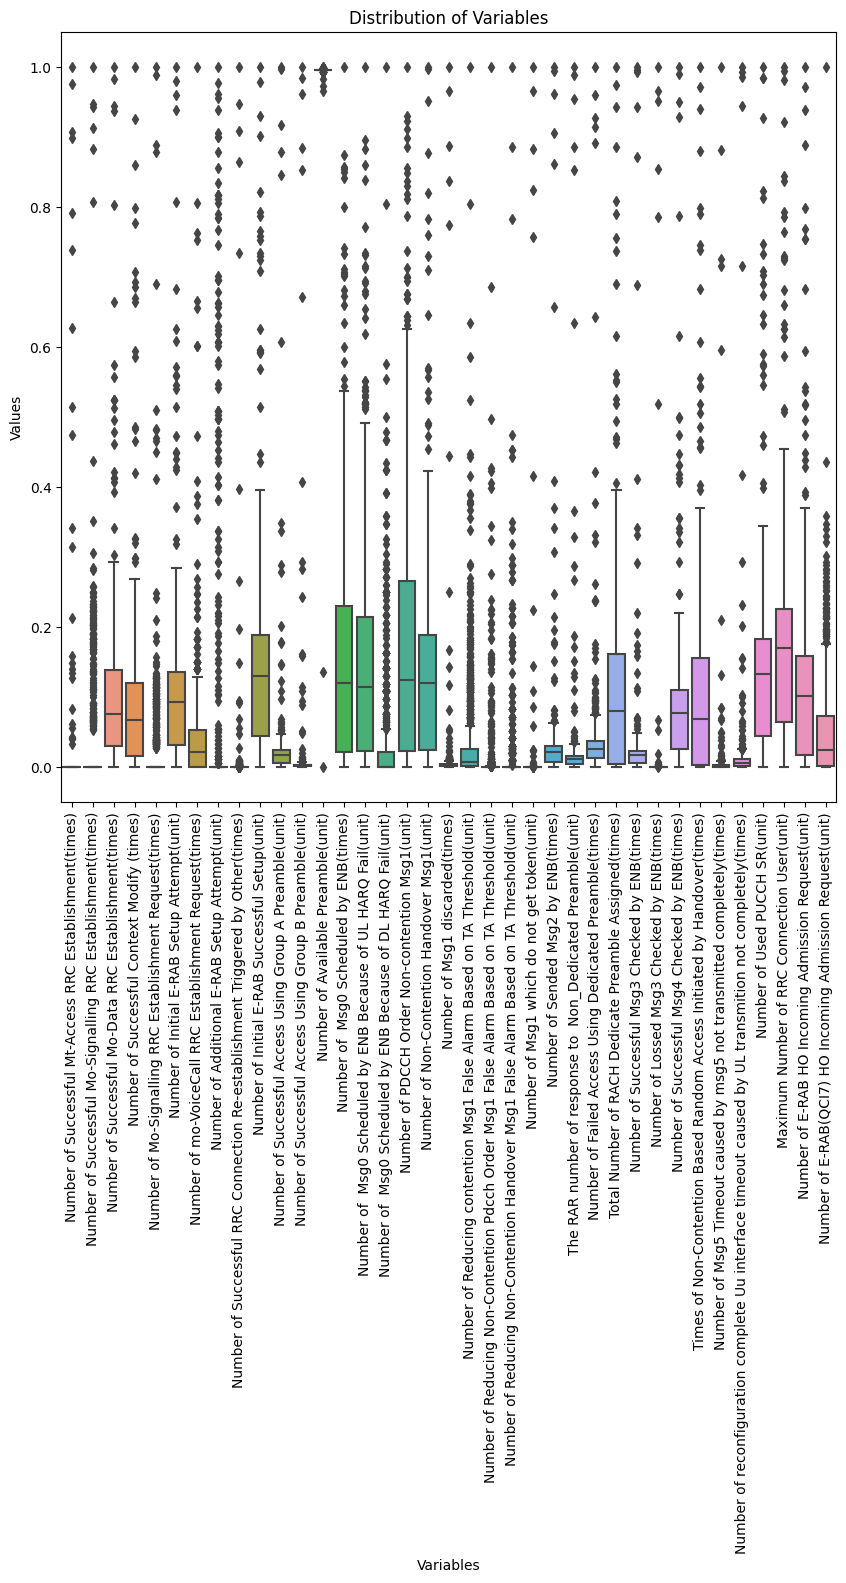

In [18]:
# Box plot
plt_df = normalizedValues(site_df,MinMaxScaler((0, 1)))

plt.figure(figsize=(10,10))
sns.boxplot(data=plt_df)
plt.xticks(rotation=90)
plt.xlabel('Variables')
plt.ylabel('Values')
plt.title('Distribution of Variables')
plt.show()

### Decompose Time-Series to See Components (Trend, Seasonality, Noise, etc)

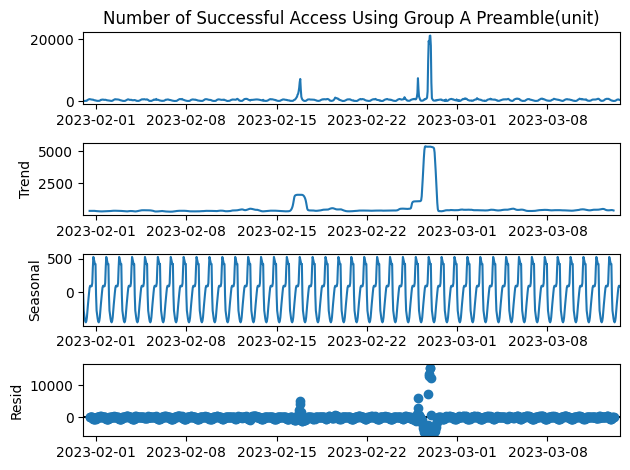

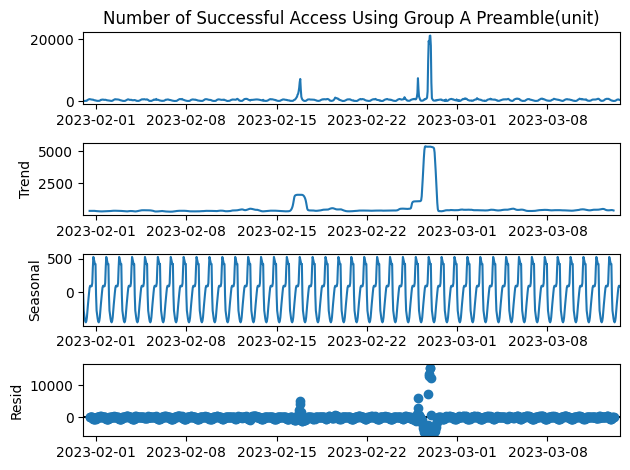

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
col = site_df.columns[10]
df_plot = site_df[col][:1000]

sd = seasonal_decompose(df_plot, model='additive', period=24)
sd.plot()

## DeTrend the data
Since we analyzing time series data, it is necessary to remove the trend component in order to focus on the underlying patterns and relationships in the data. This can be done using various methods, such as Moving average and Detrend function.

Moving average is a smoothing technique that involves computing the average of a fixed number of consecutive data points in the time series, and using this average as a replacement for the original values. The idea behind moving average is to reduce the noise or random fluctuations in the data, and to highlight the underlying trends or patterns. Moving average is often used as a pre-processing step for time series analysis, but it does not remove the trend component entirely.

Detrending, on the other hand, involves fitting a regression line to the time series data and subtracting this line from the data to obtain a detrended version of the series. The resulting series has the trend component removed, leaving only the residuals or deviations from the trend. Detrending is a more precise way to remove the trend component from the data, but it can also result in the loss of information if the trend component contains important information about the underlying patterns in the data.

In general, moving average is a simpler and less precise method for removing trends from time series data, and is often used for smoothing and pre-processing purposes. Detrending is a more sophisticated method that is better suited for time series analysis and hypothesis testing, but it requires more care and attention to ensure that important information is not lost in the process.

Number of Successful Access Using Group A Preamble(unit)


<Axes: >

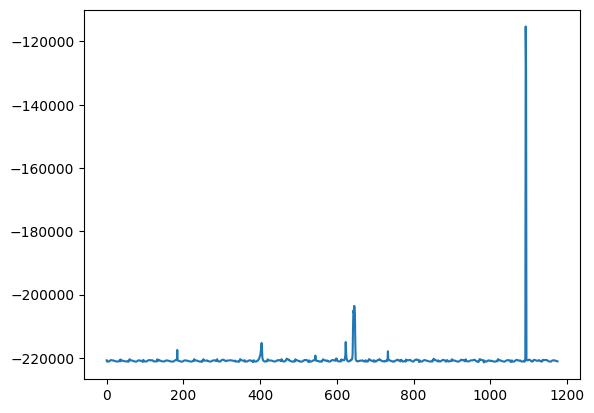

In [20]:
# Remove trend from the data
from scipy.signal import detrend

col = site_df.columns[10]
print(col)
#site_df_detrended = normalizedValues(site_df,StandardScaler()) 
#[StandardScaler() or MinMaxScaler((0, 1))]
site_df_detrended = pd.DataFrame(detrend(site_df), columns=site_df.columns)

site_df_detrended[col].plot()

In [21]:
#We investigate the possibility to get the running mean for a window of 30-60-90 days \
#in order to make the distribution of values more linear
#As you increase the windows the average become more and more linear
import plotly.graph_objects as go
col = site_df.columns[3]
print(col)

df_plt = site_df[col][1:1000].copy()
#df_plt = df_plt.set_index('datetime')
#df_plt.index =  pd.DatetimeIndex(df_plt.index)
#df_plt = df_plt[col].resample('H').mean()

DateMVA1 = df_plt.rolling(window=24).mean()
DateMVA2 = df_plt.rolling(window=168).mean()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_plt.index, y=df_plt.values,
                    mode='lines',
                    name='Amount per Day')
             )

fig.add_trace(go.Scatter(x=DateMVA1.index, y=DateMVA1.values,
                    mode='lines',
                    name='Moving Average for 24 Hours')
             )

fig.add_trace(go.Scatter(x=DateMVA2.index, y=DateMVA2.values,
                    mode='lines',
                    name='Moving Average for 168 Hours')
             )


fig.show()

Number of Successful Context Modify (times)


# Split the Data and Fit the Models

In [22]:
#Prepare function to use for each find outliers and assign to the dataframe indication

def find_boundaries(df, variable,q1=0.01,q2=0.99):
    # the boundaries are the quantiles
    lower_boundary = df[variable].quantile(q1) # lower quantile
    upper_boundary = df[variable].quantile(q2) # upper quantile
    return upper_boundary, lower_boundary

def flag_outliers(df,variable,q1=0.01,q2=0.99):
    outlier = df.copy()
    upper_boundary,lower_boundary =  find_boundaries(df,variable,q1,q2)
    #print('{}-{}'.format(upper_boundary,lower_boundary))
    outlier['FailureIndicator'] = (outlier[variable] < lower_boundary)|(outlier[variable] > upper_boundary)
    outlier['FailureIndicator'] = outlier['FailureIndicator'].astype(int)
    #outlier['FailureIndicator'] = [1 if i==True else 0 for i in outlier['FailureIndicator']]
    return outlier

def get_outliers(df,variable,q1=0.01,q2=0.99):
    outlier = df.copy()
    upper_boundary,lower_boundary =  find_boundaries(df,variable,q1,q2)
    #print('{}-{}'.format(upper_boundary,lower_boundary))
    outlier  = outlier.loc[(outlier[variable] < lower_boundary)|(outlier[variable] > upper_boundary)]
    #outlier[variable] = np.where(outlier[variable] > upper_boundary, upper_boundary,
    #                   np.where(outlier[variable] < lower_boundary, lower_boundary, outlier[variable]))
    return outlier

In [80]:
## the the datatime index and group the data by hour
def splitData(df, train_pct = 0.7):
    # get the unique dates from the index
    unique_days = pd.Series(df.index.date).unique()
    
    # calculate the number of rows for the training set
    train_size = int(len(unique_days) * train_pct)
    print(train_size)
        
    # calculate the end time of the training set
    train_end_time = df.index.min() + pd.Timedelta(train_size, unit="d")
    print(train_end_time)
    
    # separate the dataframe into training and testing sets
    train_df = df.loc[:train_end_time]
    test_df = df.loc[train_end_time + pd.Timedelta(hours=1):]
    
    return train_df,test_df

def plot_resuls(df,outliers,incident,col):
    print(col)
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(df.index, df[col], color='blue', label = 'Normal')
    ax.scatter(outliers.index,outliers, color='black', label = 'Anomaly')
    ax.scatter(incident.index,incident, color='red', label = 'Incident')
    plt.title(col)
    plt.legend()
    plt.show();
    return

def plotRocCurve(y_test,score):
    # Compute the FPR, TPR, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, score)
    # Calculate AUC
    auc_score = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--')  # diagonal line representing random classifier
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show();
    return
    
def plotConfusionMatrix(y_test,y_pred):
    from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
    labels = ['Normal','Outlier']
    cm = confusion_matrix(y_test,y_pred, normalize = "true")
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= labels)
    disp.plot();
    return

def plot_results(df,failures,pred, col):
    # Obtain outlier scores and true labels
    failures = df.loc[failures, col]

    # Create an array indicating the anomaly points
    outliers = df.loc[pred, col] #anomaly

    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(df.index, df[col], color='blue', label = 'Actual')
    ax.scatter(failures.index,failures, s=60, color='red', label = 'Failure')
    ax.scatter(outliers.index,outliers, s=20, color='black', label = 'Anomaly')
    plt.title(col)
    plt.legend()
    plt.show();
    return

(1176, 97)
(1176, 24)
Number of Successful Mo-Signalling RRC Establishment(times)


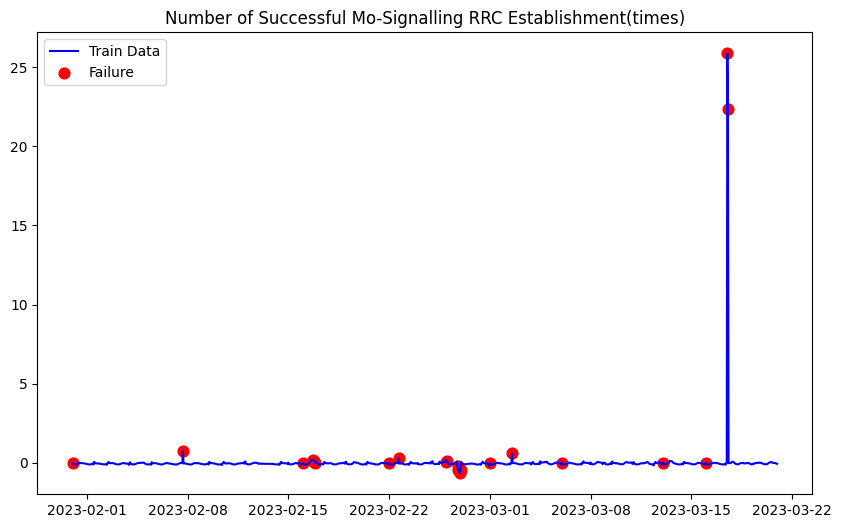

In [25]:
def getdata(df,sitecode_, fillNa_=24, scaler_ = StandardScaler(), detrendby_ ='detrend',rolling_window_=24, metrics_ ='All', failure_metrics_ = None, lag= 0):
    """
    Provide a new dataframe with data and labels according to the parameters that you can provide

    Args:
        df (pandas.DataFrame): The input DataFrame.
        sitecode_: The input DataFrame.
        fillNa_: The window of time that used for roaling avg to fill NAs
        scaler_: The value scalre model [StandardScaler() or MinMaxScaler((0, 1))]
        detrendby_: The Detrend method [detrend,rolling]
        rolling_window_: The number of time window in case of Detrend by rolling
        metrics_(list): The list of features that need to return 
        failure_metrics_(list): The list of features that contains failure info
    Returns:
        dfdata(pandas.DataFrame): The final dataset that could be used for model fiting
        failures_df(pandas.DataFrame):  The lable (target) of this dataset that could be used for model traing
        incidents_df(pandas.DataFrame): The lable (incidents) of this dataset that could be used for model evaluation
    """
    ##############################################################
    dfdata = df.loc[df['SiteCode'] == sitecode_].copy()
    dfdata = dfdata.drop('SiteCode', axis=1)
    
    ##############################################################
    dfdata = fillNa(dfdata,fillNa_)

    ##############################################################
    incidents_df = dfdata['incident']
    incidents_df = incidents_df.reset_index().set_index('datetime').fillna(False)
    incidents_df = incidents_df[lag:]
    dfdata = dfdata.drop('incident', axis=1)    
    
    ##############################################################
    if(detrendby_ == 'detrend'):
        dfdata_detrended = pd.DataFrame(detrend(dfdata), columns=dfdata.columns)
        dfdata_detrended['datetime'] = dfdata.index
        dfdata_detrended = dfdata_detrended.set_index('datetime')
        dfdata = dfdata_detrended.copy()

    elif(detrendby_ == 'rolling'):
        dfdata = rollingAvg(dfdata,rolling_window_)
        
    ##############################################################
    if(metrics_ != 'All'):
        #failures_df = dfdata[failure_metrics_].copy()
        failures_df = normalizedValues(dfdata[failure_metrics],scaler_)
        lof = LocalOutlierFactor()
        outlier = lof.fit_predict(failures_df.values)
        failures_df['FalureKPIsMean'] = failures_df.mean(axis=1)
        failures_df = failures_df['FalureKPIsMean'].reset_index().set_index('datetime').fillna(False)
        #failures_df['FailureIndicator'] = (outlier == -1)
        failures_df = flag_outliers(failures_df,'FalureKPIsMean',0.01,0.99)
        failures_df = failures_df.shift(lag).dropna()
        dfdata = dfdata[lag:]
        dfdata = dfdata[metrics_]
        
    #dfdata['FalureKPIsMean'].shift(lag).fillna(method='bfill').head(10)
    ##############################################################
    dfdata = remove_low_variance_features(dfdata,0.05)
    print(dfdata.shape)
    dfdata = remove_high_corr_features(dfdata,0.999)
    print(dfdata.shape)

    dfdata = normalizedValues(dfdata,scaler_) 
    ##############################################################
        
    if(metrics_ == 'All'):
        return dfdata,None, incidents_df
    
    return dfdata, failures_df, incidents_df
##############################################################


dfdata, failures_df, incidents_df = getdata(dsbysite, 'LIM003', 6, StandardScaler(),'detrend',12,kpis_metrics,failure_metrics, 0)

col = dfdata.columns[1]
#col = 'Maximum Number of RRC Connection User(unit)'
failures = dfdata.loc[failures_df['FailureIndicator'] == True, col]

print(col)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(dfdata.index, dfdata[col], color='blue', label = 'Train Data')
ax.scatter(failures.index,failures, s=60, color='red', label = 'Failure')

plt.title(col)
plt.legend()
plt.show();


# Explore the relationships between variables and identify potential causal factors

Use Granger causality analysis, which is a statistical method that examines whether one time series variable can be used to predict another time series. This method can be used to determine whether there is a causal relationship between two time series, and to identify the direction of causality.

When exploring the relationships between time series data and global issues, it can also be useful to consider other contextual factors that may be driving the observed correlations. For example, changes in economic conditions or political factors may be influencing both the global issue and the time series data, and failing to account for these factors can lead to spurious correlations or incorrect causal inferences.

- "ssr based F test" A low F-value and a high p-value (usually > 0.05) indicate no significant causal relationship.
- "likelihood ratio test": This column shows the results of the likelihood ratio test, which compares the likelihood of the restricted model to the likelihood of the unrestricted model. The test is based on the log-likelihood ratio, and a high chi-squared value and a low p-value (usually < 0.05) indicate a significant causal relationship.    
- The test is based on the log-likelihood ratio, and a high chi-squared value and a high p-value (usually > 0.05) indicate no significant causal relationship.

### We execute a this Causality Test for all compination varables

In [27]:
from statsmodels.tsa.stattools import grangercausalitytests
dfdata, failures_df, incidents_df = getdata(dsbysite, 'LIM003', 6, StandardScaler(),'detrend',24,kpis_metrics,failure_metrics,0)  

lst = []
maxlag = 6

dfdata['FalureKPIsMean'] = failures_df['FalureKPIsMean']

for a in  dfdata.columns:
    cols = [a,'FalureKPIsMean']
    results = grangercausalitytests(dfdata[cols], maxlag=maxlag, verbose=False)
    pvalue_lag = []
    for i in range(maxlag):
        lag = results[i+1][0]["ssr_ftest"][1]
        pvalue_lag.append(lag)
        
    var = [a,'FalureKPIsMean'] #.extend(pvalue_lag)
    var.extend(pvalue_lag)
    lst.append(var) 
    
lables = ['var1','var2']
for i in range(maxlag):
    lables.extend(['pvalue_lag'+str(i+1)])

df_causality= pd.DataFrame(lst, columns=lables)
df_causality.sort_values('pvalue_lag5').head(5)

(1176, 97)
(1176, 24)


var1            var2  \
14                Number of Sended Msg2 by ENB(times)  FalureKPIsMean   
8   Number of Successful Access Using Group A Prea...  FalureKPIsMean   
18    Number of Successful Msg3 Checked by ENB(times)  FalureKPIsMean   
20                      Number of Used PUCCH SR(unit)  FalureKPIsMean   
15  The RAR number of response to  Non_Dedicated P...  FalureKPIsMean   

     pvalue_lag1   pvalue_lag2   pvalue_lag3   pvalue_lag4   pvalue_lag5  \
14  1.309091e-24  3.255971e-54  6.990962e-53  5.896267e-46  4.198562e-49   
8   4.656039e-26  2.431896e-53  6.875823e-51  3.493210e-45  1.441529e-48   
18  3.964358e-27  1.126276e-53  1.580088e-48  1.182959e-44  7.481715e-47   
20  6.436891e-05  5.877783e-31  2.019781e-37  3.032566e-38  4.354019e-41   
15  5.726405e-19  2.116916e-43  4.087123e-43  1.954983e-36  2.821786e-39   

     pvalue_lag6  
14  5.062972e-52  
8   2.201484e-51  
18  3.364034e-47  
20  5.912829e-41  
15  1.886005e-45

In [29]:
for i in range(maxlag):
    label = 'pvalue_lag'+str(i+1)
    cfno = df_causality.loc[df_causality[label] < 0.05].shape[0]
    print('Number of Variable with p-value < 0.05 for lag {} is: {} Fields {}'.format(i+1,cfno/df_causality.shape[0],cfno))

Number of Variable with p-value < 0.05 for lag 1 is: 0.6 Fields 15
Number of Variable with p-value < 0.05 for lag 2 is: 0.68 Fields 17
Number of Variable with p-value < 0.05 for lag 3 is: 0.64 Fields 16
Number of Variable with p-value < 0.05 for lag 4 is: 0.64 Fields 16
Number of Variable with p-value < 0.05 for lag 5 is: 0.6 Fields 15
Number of Variable with p-value < 0.05 for lag 6 is: 0.6 Fields 15


In [30]:
# Shift the data for lag = 5 and fill the nulls 
lag = 6
dfdata['FalureKPIsMean'].shift(lag).fillna(method='bfill').head(10)

datetime
2023-01-31 00:00:00    0.119076
2023-01-31 01:00:00    0.119076
2023-01-31 02:00:00    0.119076
2023-01-31 03:00:00    0.119076
2023-01-31 04:00:00    0.119076
2023-01-31 05:00:00    0.119076
2023-01-31 06:00:00    0.119076
2023-01-31 07:00:00    0.061737
2023-01-31 08:00:00    0.069122
2023-01-31 09:00:00    0.071165
Name: FalureKPIsMean, dtype: float64

In [31]:
### the top lag5
top_var = 'Number of Successful Mo-Data RRC Establishment(times)'
#df_causality.sort_values('pvalue_lag2', ascending=True)['var1'][1]
print(top_var)
cols = [top_var,'FalureKPIsMean']
print(cols)
results = grangercausalitytests(dfdata[cols], maxlag=5)

for lag in results.keys():
    # p-value for each lag, which indicates the statistical significance of the causal relationship between the two time series.
    print(f'Lag {lag}: p-value = {results[lag][0]["ssr_ftest"][1]:.4f}')    

Number of Successful Mo-Data RRC Establishment(times)
['Number of Successful Mo-Data RRC Establishment(times)', 'FalureKPIsMean']

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7140  , p=0.0097  , df_denom=1172, df_num=1
ssr based chi2 test:   chi2=6.7312  , p=0.0095  , df=1
likelihood ratio test: chi2=6.7120  , p=0.0096  , df=1
parameter F test:         F=6.7140  , p=0.0097  , df_denom=1172, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.8902  , p=0.0011  , df_denom=1169, df_num=2
ssr based chi2 test:   chi2=13.8392 , p=0.0010  , df=2
likelihood ratio test: chi2=13.7583 , p=0.0010  , df=2
parameter F test:         F=6.8902  , p=0.0011  , df_denom=1169, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.7880  , p=0.0025  , df_denom=1166, df_num=3
ssr based chi2 test:   chi2=14.4503 , p=0.0024  , df=3
likelihood ratio test: chi2=14.3620 , p=0.0025  , df=3
parameter F test:         F=4.78

##### based on the reported results, there is evidence to support the notion that the past values have a significant relationship with the future FalureKPIsMean in the context of Granger causality.
###### choose lags = 2
- SSR based F-test: F-statistic is 6.8902, and the associated p-value is 0.0011. A low p-value suggests that the past values of the "value" variable significantly help in predicting the future values of the "target variable."
- SSR based chi2 test:  The chi-square statistic is 13.8392, and the corresponding p-value is 0.0010.  
- Likelihood ratio test: This test compares the likelihoods of two competing statistical models, one including the past values of the "value" variable and the other without it. The chi-square statistic is 13.7583, and the associated p-value is 0.0010.
- Parameter F-test: This test assesses the overall significance of the regression model. The F-statistic is 6.8902, and the p-value is 0.0011. 

In [32]:
kpis_metrics_causal_relationship = list(df_causality.loc[df_causality['pvalue_lag2'] < 0.05]['var1'].values)
print(len(kpis_metrics_causal_relationship), len(dfdata.columns))
kpis_metrics_causal_relationship

17 25


['Number of Successful Mo-Data RRC Establishment(times)',
 'Number of Initial E-RAB Setup Attempt(unit)',
 'Number of Successful delayTolerantAccess RRC Establishment(times)',
 'Number of Initial E-RAB Successful Setup(unit)',
 'Number of Successful Access Using Group A Preamble(unit)',
 'Number of Successful Access Using Group B Preamble(unit)',
 'Number of Msg1 discarded(times)',
 'Number of Msg1 which do not get token(unit)',
 'Number of Sended Msg2 by ENB(times)',
 'The RAR number of response to  Non_Dedicated Preamble(unit)',
 'Number of Failed Access Using Dedicated Preamble(times)',
 'Number of Successful Msg3 Checked by ENB(times)',
 'Maximum transfer Number of UE shcheduled Request reached(times)',
 'Number of Used PUCCH SR(unit)',
 'Number of Used PUCCH CQI(unit)',
 'Number of Dedicated Cell Reselections Based on the ENDC Anchor Function(times)',
 'Number of E-RAB HO Incoming Admission Request(unit)']

## Investigating Pamateres by Visualizing the results

### Prepare dataset for training and validation

### Tuning Hyperparameter
#### Compare IsolationForest Vs LocalOutlierFactor

In [49]:
dfdata, failures_df, incidents_df = getdata(dsbysite, 'LIM003', 6, StandardScaler(),'detrend',24,kpis_metrics_causal_relationship,failure_metrics,0)  
#failure_metrics, kpis_metrics
#PAF024 LIM003
########################################################
print('Missing Values {}'.format(len(getMissingValues(dfdata))))
x_train,x_test = splitData(dfdata,0.7)
x_train,x_test = x_train.values,x_test.values

y_train,y_test = splitData(failures_df,0.7)
y_train,y_test = y_train['FailureIndicator'].values,y_test['FailureIndicator'].values


(1176, 17)
(1176, 17)
Missing Values 0
34
2023-03-06 00:00:00
34
2023-03-06 00:00:00


In [50]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import time


# Generate artificial true labels assuming equal number of normal and anomalous instances
num_instances = len(y_test)
zeros = num_instances // 2
once = num_instances - zeros
true_labels = np.concatenate((np.zeros(zeros), np.ones(once)))

models = [IsolationForest(random_state=42),LocalOutlierFactor(novelty=True)]
model_names = ['IsolationForest','LocalOutlierFactor']

results = []

for i, m in enumerate(models):
    tstart = time.time()
    # Keep only the normal data for the training dataset
    X_train_normal = x_train[np.where(y_train == False)]
    
    model = m.fit(x_train, y_train)
    
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    y_pred_train = (y_pred_train==-1)
    y_pred_test = (y_pred_test==-1)  
    
    # Compute error
    train_rmse = mean_squared_error(y_train, y_pred_train)**0.5
    test_rmse = mean_squared_error(y_test, y_pred_test)**0.5
    r2 = r2_score(y_test,y_pred_test)
    
    # Obtain the anomaly scores for the test data
    anomaly_scores = -m.decision_function(x_train)
    train_roc = roc_auc_score(y_train,anomaly_scores)

    anomaly_scores = -m.decision_function(x_test)
    test_roc = roc_auc_score(y_test,anomaly_scores)   
    
    print(m)
    print(classification_report(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test))
    
    tend = time.time()
    rs = [train_rmse,test_rmse,r2,train_roc,test_roc,tend - tstart]
    results.append(rs)
    
columns=["train_rmse","test_rmse","r2","Train_RocAuc","Test_RocAuc","seconds"]
pd.DataFrame(results, columns=columns, index=model_names)

IsolationForest(random_state=42)
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       355
           1       0.18      0.50      0.27         4

    accuracy                           0.97       359
   macro avg       0.59      0.74      0.63       359
weighted avg       0.99      0.97      0.98       359

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       355
           1       0.18      0.50      0.27         4

    accuracy                           0.97       359
   macro avg       0.59      0.74      0.63       359
weighted avg       0.99      0.97      0.98       359

LocalOutlierFactor(novelty=True)
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       355
           1       0.11      0.75      0.19         4

    accuracy                           0.93       359
   macro avg       0.55      0.84      0.58       359
weighted

train_rmse  test_rmse        r2  Train_RocAuc  \
IsolationForest       0.212809   0.175045 -1.780986      0.982309   
LocalOutlierFactor    0.286369   0.263890 -5.320423      0.980176   

                    Test_RocAuc   seconds  
IsolationForest        0.957746  0.474863  
LocalOutlierFactor     0.953521  0.244013

### IsolationForest

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, f1_score, accuracy_score, roc_auc_score

dfdata, failures_df, incidents_df = getdata(dsbysite, 'LIM003', 6, StandardScaler(),'detrend',24,kpis_metrics_causal_relationship,failure_metrics,0)  
#failure_metrics, kpis_metrics
#PAF024 LIM003
########################################################

x_train,x_test = splitData(dfdata,0.7)
x_train,x_test = x_train.values,x_test.values

y_train,y_test = splitData(failures_df,0.7)
y_train,y_test = y_train['FailureIndicator'].values,y_test['FailureIndicator'].values

# Generate artificial true labels assuming equal number of normal and anomalous instances
#num_instances = len(x_train)
#zeros = num_instances // 2
#once = num_instances - zeros
#true_labels = np.concatenate((np.zeros(zeros), np.ones(once)))

# create an instance of the IsolationForest class
model = IsolationForest(random_state=42) 

# define the parameter grid for hyperparameter tuning
param_grid = {'n_estimators': [5, 10, 20,50]
              ,'max_samples': [0.5, 0.75, 1.0]
              , 'contamination': [0.01,0.02,0.05, 0.1, 0.15]}


# define a custom scorer function
def custom_scorer(model, X, y):
    #y_pred = model.predict(X)  # outliers
    # Compute the FPR, TPR, and thresholds
    score = -model.decision_function(X)
    fpr, tpr, thresholds = roc_curve(y, score)
    #print(convert_to_binary(y_test))
    # Calculate AUC
    auc_score = auc(fpr, tpr)
    return auc_score

# create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=custom_scorer)



# fit the GridSearchCV object to the data
grid_search.fit(x_train, y_train)

# print the best hyperparameters and the corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

(1176, 17)
(1176, 17)
34
2023-03-06 00:00:00
34
2023-03-06 00:00:00
Best hyperparameters: {'contamination': 0.01, 'max_samples': 1.0, 'n_estimators': 50}
Best score: 0.9883835939439066


(1176, 17)
(1176, 17)
34
2023-03-06 00:00:00
34
2023-03-06 00:00:00


C:\Users\GeorgiosCh\AppData\Local\Temp\2\ipykernel_13232\3598133730.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\GeorgiosCh\AppData\Local\Temp\2\ipykernel_13232\3598133730.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



['Number of Sended Msg2 by ENB(times)']


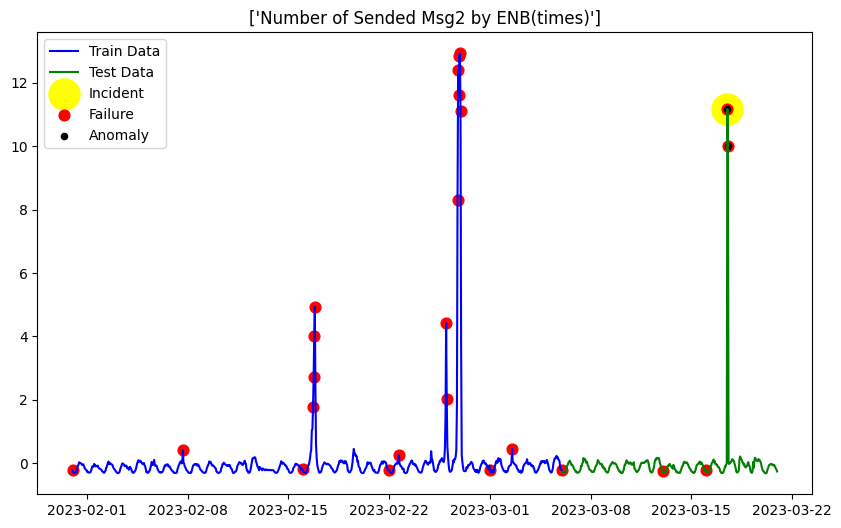

[[0.99439776 0.00560224]
 [0.         1.        ]]


FailureIndicator  outliers     score
datetime                                                 
2023-03-17 12:00:00                 1        -1  0.099186
2023-03-17 13:00:00                 1        -1  0.099186

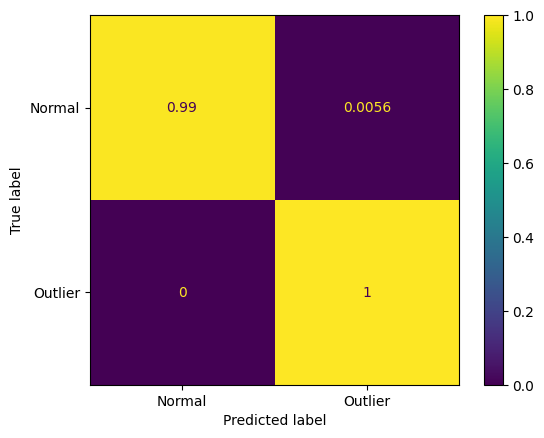

In [53]:
#pd.options.mode.chained_assignment = None

dfdata, failures_df, incidents_df = getdata(dsbysite, 'LIM003', 6, StandardScaler(),'detrend',24,kpis_metrics_causal_relationship,failure_metrics,0)  
#failure_metrics, kpis_metrics
#PAF024 LIM003 LIM090
########################################################
# Obtain outlier scores and true labels
failures_df = failures_df['FailureIndicator'].reset_index().set_index('datetime')
########################################################
x_train,x_test = splitData(dfdata,0.7)
#x_train,x_test = x_train.values,x_test.values

y_train,y_test = splitData(failures_df,0.7)
#y_train,y_test = y_train.values,y_test.values


#########################################################
#n_estimators=n_estimators, contamination=contamination, max_samples=max_sample
model = IsolationForest(random_state=42,n_estimators=50,contamination= 0.01, max_samples =  0.75) 
#{'contamination': 0.01, 'max_samples': 0.75, 'n_estimators': 5}
model.fit(x_train.values)

#########################################################
#print(model.estimator_)
pred_data = model.predict(x_test.values)
y_test['outliers'] = pred_data
y_test['score'] = -model.decision_function(x_test.values)
#model.negative_outlier_factor_

#########################################################
## select the top
col = df_causality.sort_values('pvalue_lag5')['var1'].head(1).values
#col = pred_data.columns[3]

#col = 'Maximum Number of RRC Connection User(unit)'
outliers = x_test.loc[y_test['outliers'] == -1, col] #anomaly
incident = dfdata.loc[incidents_df['incident'] == True, col] #incident
failures = dfdata.loc[failures_df['FailureIndicator'] == True, col]

print(col)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x_train.index, x_train[col], color='blue', label = 'Train Data')
ax.plot(x_test.index, x_test[col], color='green', label = 'Test Data')
ax.scatter(incident.index,incident, s=500,color='yellow', label = 'Incident')
ax.scatter(failures.index,failures, s=60, color='red', label = 'Failure')
ax.scatter(outliers.index,outliers, s=20, color='black', label = 'Anomaly')

plt.title(col)
plt.legend()
plt.show();


labels = ['Normal','Outlier']
y_pred = (y_test['outliers'].values==-1)
y = y_test['FailureIndicator'].values #(y_test['FailureIndicator'].values == True)
cm = confusion_matrix(y_pred,y, normalize = "true")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= labels)
disp.plot()

#########################################################
# Filter the original data to only include the non-outliers
otls = y_test.loc[y_test['outliers'] == -1]
otls.sort_values('score').head(10)


### LocalOutlierFactor

In [56]:
dfdata, failures_df, incidents_df = getdata(dsbysite, 'LIM003', 24, StandardScaler(),'detrend',24,kpis_metrics,failure_metrics,0)  
#failure_metrics, kpis_metrics
#PAF024 LIM003
########################################################
# Obtain outlier scores and true labels
failures_df = failures_df['FailureIndicator'].reset_index().set_index('datetime')
########################################################
print('Missing Values {}'.format(len(getMissingValues(dfdata))))
x_train,x_test = splitData(dfdata,0.7)
x_train,x_test = x_train.values,x_test.values

y_train,y_test = splitData(failures_df,0.7)
y_train,y_test = y_train.values,y_test.values

##############################################################

# create an instance of the LocalOutlierFactor class
model = LocalOutlierFactor() 

# define the parameter grid for hyperparameter tuning
param_grid = {'n_neighbors': [5, 10, 20, 30,50], 
              'contamination': [0.02,0.05, 0.1, 0.15],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'novelty' : [False]}


# define a custom scorer function
def custom_scorer(model, X, y):
    y_pred = model.fit_predict(X)  # outliers
    # Compute the FPR, TPR, and thresholds
    score = -model.negative_outlier_factor_
    fpr, tpr, thresholds = roc_curve(y, score)
    #print(convert_to_binary(y_test))
    # Calculate AUC
    auc_score = auc(fpr, tpr)
    return auc_score

# create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=custom_scorer)

# fit the GridSearchCV object to the data
grid_search.fit(x_train, y_train)

# print the best hyperparameters and the corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

#custom_scorer = make_scorer(custom_scorer, greater_is_better=False, needs_proba=False, needs_threshold=False)


(1176, 97)
(1176, 24)
Missing Values 0
34
2023-03-06 00:00:00
34
2023-03-06 00:00:00
Best hyperparameters: {'algorithm': 'auto', 'contamination': 0.02, 'n_neighbors': 20, 'novelty': False}
Best score: 0.9742742202366179


(1176, 17)
(1176, 17)
Missing Values 0
34
2023-03-06 00:00:00
34
2023-03-06 00:00:00
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       355
           1       0.40      0.50      0.44         4

    accuracy                           0.99       359
   macro avg       0.70      0.75      0.72       359
weighted avg       0.99      0.99      0.99       359

['Number of Sended Msg2 by ENB(times)']


C:\Users\GeorgiosCh\AppData\Local\Temp\2\ipykernel_13232\991171855.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\GeorgiosCh\AppData\Local\Temp\2\ipykernel_13232\991171855.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



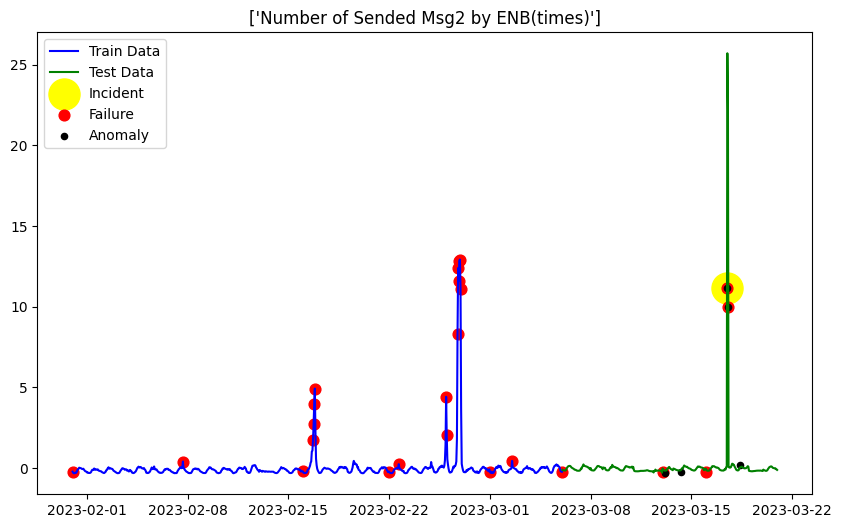

[[0.9915493 0.0084507]
 [0.5       0.5      ]]


FailureIndicator  outliers       score
datetime                                                   
2023-03-18 09:00:00                 0        -1    0.281281
2023-03-13 04:00:00                 0        -1    0.455257
2023-03-14 06:00:00                 0        -1    0.711838
2023-03-17 13:00:00                 1        -1  213.872969
2023-03-17 12:00:00                 1        -1  247.465506

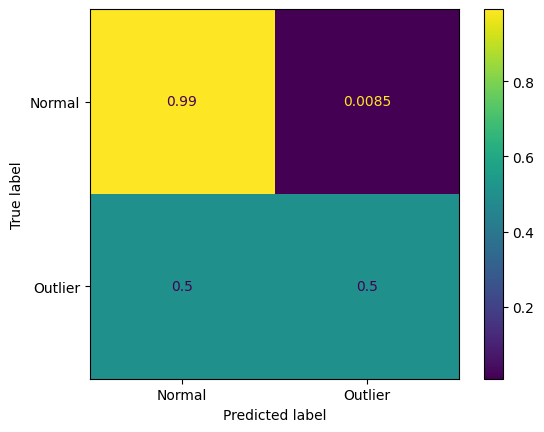

In [58]:
#pd.options.mode.chained_assignment = None

dfdata, failures_df, incidents_df = getdata(dsbysite, 'LIM003', 6, StandardScaler(),'detrend',24,kpis_metrics_causal_relationship,failure_metrics,0)  
#failure_metrics, kpis_metrics
#PAF024 LIM003 LIM090
########################################################
# Obtain outlier scores and true labels
failures_df = failures_df['FailureIndicator'].reset_index().set_index('datetime')
########################################################
print('Missing Values {}'.format(len(getMissingValues(dfdata))))
x_train,x_test = splitData(dfdata,0.7)
#x_train,x_test = x_train.values,x_test.values

########################################################
y_train,y_test = splitData(failures_df,0.7)
#y_train,y_test = y_train.values,y_test.values

# Keep only the normal data for the training dataset
#X_train_normal = x_train[np.where(y_train == False)]
X_train_normal = x_train.loc[y_train['FailureIndicator'] == False]


#########################################################
#n_estimators=n_estimators, contamination=contamination, max_samples=max_sample
model = LocalOutlierFactor(algorithm = 'auto', contamination=  0.02, n_neighbors = 20, novelty = True) 
# {'algorithm': 'auto', 'contamination': 0.02, 'n_neighbors': 50, 'novelty': False}

model.fit(X_train_normal.values) #x_train.values, y_train.values

#########################################################
#print(model.estimator_)
pred_data = model.predict(x_test.values)

prediction_outlier = [1 if i==-1 else 0 for i in pred_data]
print(classification_report(y_test, prediction_outlier))


y_test['outliers'] = pred_data
y_test['score'] = -model.decision_function(x_test.values)
#model.negative_outlier_factor_

#########################################################
## select the top
col = df_causality.sort_values('pvalue_lag5')['var1'].head(1).values
#col = pred_data.columns[3]

#col = 'Maximum Number of RRC Connection User(unit)'
outliers = x_test.loc[y_test['outliers'] == -1, col] #anomaly
incident = dfdata.loc[incidents_df['incident'] == True, col] #incident
failures = dfdata.loc[failures_df['FailureIndicator'] == True, col]

print(col)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x_train.index, x_train[col], color='blue', label = 'Train Data')
ax.plot(x_test.index, x_test[top_var], color='green', label = 'Test Data')
ax.scatter(incident.index,incident, s=500,color='yellow', label = 'Incident')
ax.scatter(failures.index,failures, s=60, color='red', label = 'Failure')
ax.scatter(outliers.index,outliers, s=20, color='black', label = 'Anomaly')

plt.title(col)
plt.legend()
plt.show();

plotConfusionMatrix(y_test['FailureIndicator'].values,prediction_outlier)

#########################################################
# Filter the original data to only include the non-outliers
otls = y_test.loc[y_test['outliers'] == -1]
otls.sort_values('score').head(20)

In [867]:
y_test[y_test['FailureIndicator']==True]

FailureIndicator  outliers     score
datetime                                                 
2023-03-13 12:00:00               1.0         1 -6.172105
2023-03-16 12:00:00               1.0         1 -5.931789
2023-03-18 00:00:00               1.0         1 -6.203511
2023-03-18 01:00:00               1.0         1 -6.087384

## Receiver Operating Characteristic (ROC) curve
The closer the ROC curve is to the top-left corner of the plot, the better the model's performance. A perfect classifier would have an ROC curve that passes through the top-left corner, representing a TPR of 1 and an FPR of 0. The area under the ROC curve (AUC-ROC) is a common metric used to quantify the overall performance of the model, with a value ranging from 0 to 1. A higher AUC-ROC indicates better discrimination between positive and negative samples.

In [59]:
#pd.options.mode.chained_assignment = None
dfdata, failures_df, incidents_df = getdata(dsbysite, 'LIM003', 6, StandardScaler(),'detrend',24,kpis_metrics_causal_relationship,failure_metrics,2)  
#failure_metrics, kpis_metrics
#PAF024 LIM003 LIM090
########################################################
# Obtain outlier scores and true labels
failures_df = failures_df['FailureIndicator'].reset_index().set_index('datetime')
########################################################
# print('Missing Values {}'.format(len(getMissingValues(dfdata))))
x_train,x_test = splitData(dfdata,0.7)
y_train,y_test = splitData(failures_df,0.7)

########################################################
x_train,x_test = x_train.values,x_test.values
y_train,y_test = y_train.values,y_test.values


# Keep only the normal data for the training dataset
#X_train_normal = x_train[np.where(y_train == False)]
#X_train_normal = x_train.loc[y_train['FailureIndicator'] == 0].values

(1174, 17)
(1174, 17)
34
2023-03-06 02:00:00
34
2023-03-06 02:00:00


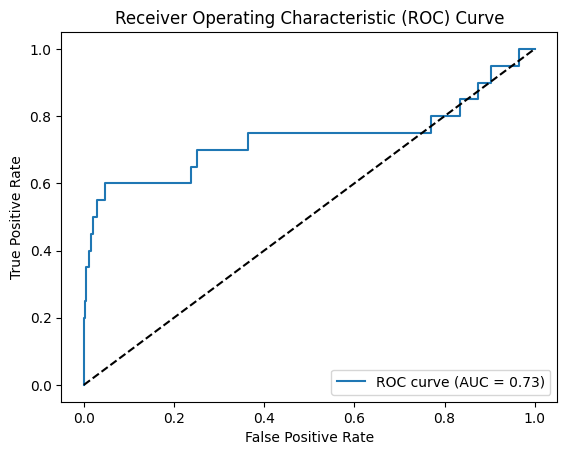

[[0.96361355 0.03638645]
 [0.45       0.55      ]]
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98       797
         1.0       0.28      0.55      0.37        20

    accuracy                           0.95       817
   macro avg       0.63      0.76      0.67       817
weighted avg       0.97      0.95      0.96       817



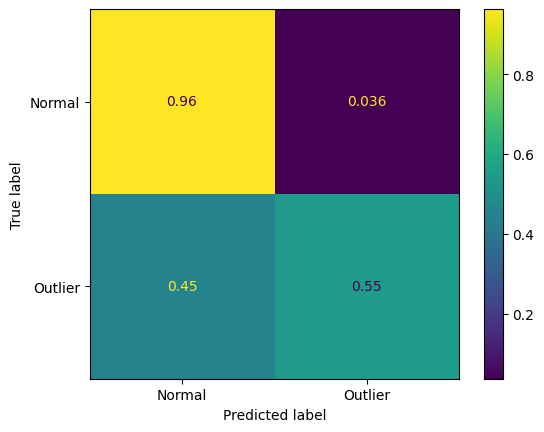

In [60]:
########################################################
model = LocalOutlierFactor(algorithm = 'auto', contamination=  0.05, n_neighbors = 50, novelty = True) 
# {'algorithm': 'auto', 'contamination': 0.02, 'n_neighbors': 50, 'novelty': False}

model.fit(x_train) #x_train.values, y_train.values
#########################################################
#print(model.estimator_)
y_pred = model.predict(x_train)
y_pred = (y_pred == -1)
scores = -model.negative_outlier_factor_
    
plotRocCurve(y_train,scores)
plotConfusionMatrix(y_train,y_pred)
print(classification_report(y_train, y_pred))


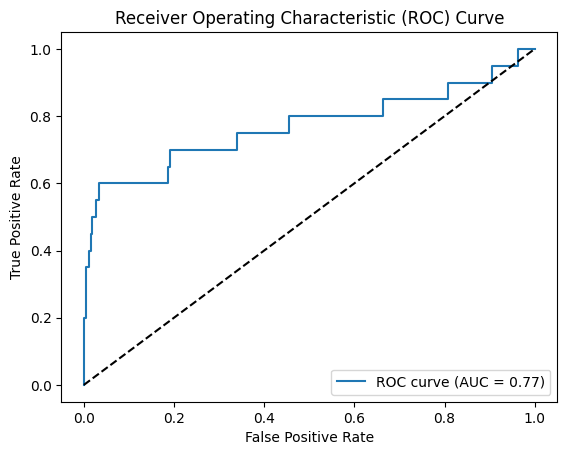

[[0.92220828 0.07779172]
 [0.4        0.6       ]]
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95       797
         1.0       0.16      0.60      0.26        20

    accuracy                           0.91       817
   macro avg       0.58      0.76      0.60       817
weighted avg       0.97      0.91      0.94       817



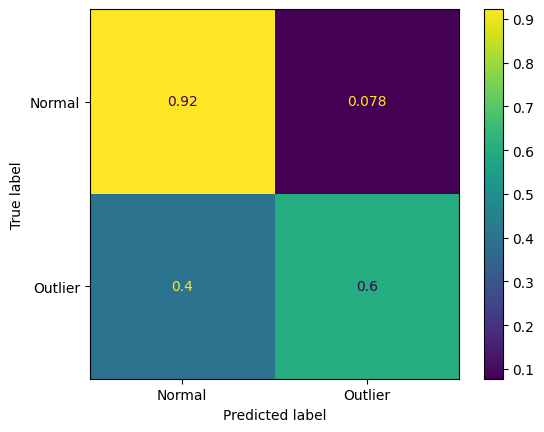

In [920]:
########################################################
model = IsolationForest(random_state=42,n_estimators=100,contamination= 0.09, max_samples = 0.5) 
# {'algorithm': 'auto', 'contamination': 0.02, 'n_neighbors': 50, 'novelty': False}

model.fit(x_train) #x_train.values, y_train.values
#########################################################
#print(model.estimator_)
y_pred = model.predict(x_train)
y_pred = (y_pred == -1)
scores = -model.decision_function(x_train)
    
plotRocCurve(y_train,scores)
plotConfusionMatrix(y_train,y_pred)
print(classification_report(y_train, y_pred))

### TimeSeriesSplit 

### F1-score
also known as the F-score, is a metric used to evaluate the performance of a binary classification model. It combines precision and recall of the model into a single score.

- The formula for F1-score is:
    f_score = f1_score(y_true, y_pred, zero_division=1)
- F1-score ranges from 0 to 1, with a higher score indicating better performance. An F1-score of 1 indicates perfect precision and recall, while an F1-score of 0 indicates poor performance.

F1-score is particularly useful when the classes in the dataset are imbalanced, meaning that there are significantly more samples of one class than the other. In such cases, accuracy may not be a good metric to use, as it can be biased towards the majority class. F1-score provides a better measure of the model's performance by taking into account both precision and recall.

#### Average Path Length (APL) 
is a measure of the average number of edges traversed by an instance in the binary tree that is constructed during the training process of the Isolation Forest model. The APL is used as a measure of the anomaly score for each instance in the data.

(1176, 17)
(1176, 17)
Window size of 12.0 hours
F1 Score     0.963860
AUC Score    0.082295
dtype: float64
['Number of Sended Msg2 by ENB(times)']


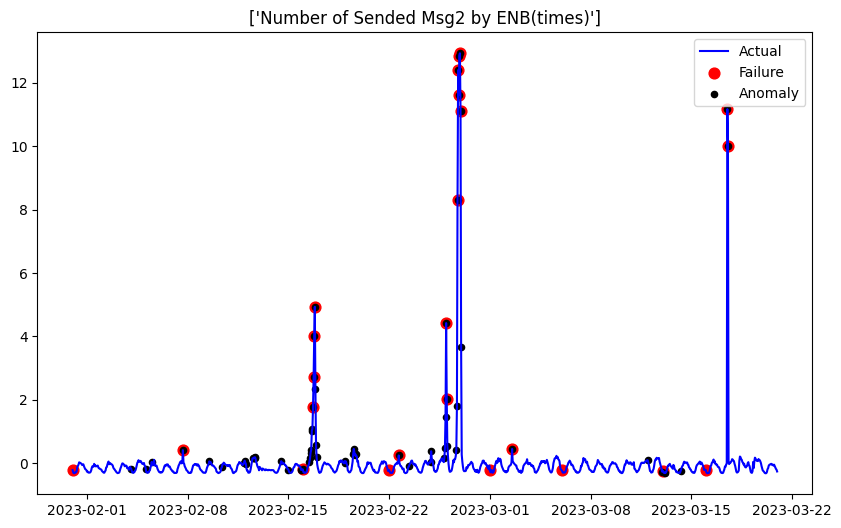

[[0.95920139 0.04079861]
 [0.25       0.75      ]]


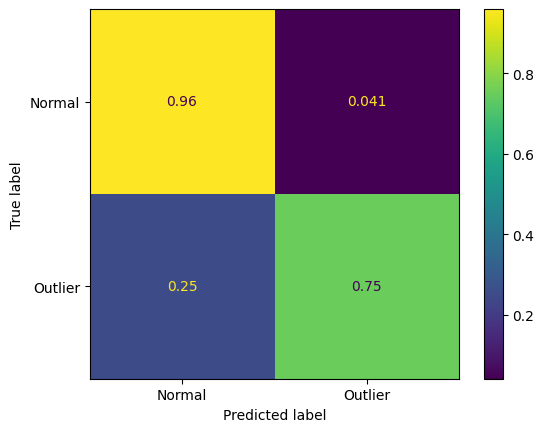

In [96]:
import warnings
warnings.filterwarnings("ignore", message="No positive samples in y_true")
warnings.filterwarnings("ignore", message="No negative samples in y_true")

#convert_to_binary(y_test.values)

dfdata, failures_df, incidents_df = getdata(dsbysite, 'LIM003', 6, StandardScaler(),'detrend',24,kpis_metrics_causal_relationship,failure_metrics,0)  
#failure_metrics, kpis_metrics
#PAF024 LIM003

# create an instance of the IsolationForest class
model = IsolationForest(random_state=42,n_estimators=5,contamination= 0.04, max_samples = 0.75)

# define the time-series cross-validation iterator
n_splits = 98
print('Window size of {} hours'.format(len(dfdata.index)/n_splits))
cv = TimeSeriesSplit(n_splits=n_splits)

# iterate over the folds and compute the F1 score for each fold
scores = []

# Create a new DataFrame to stre the prediction values
pred = pd.DataFrame({'outlier': np.ones(len(dfdata.index))}, index=dfdata.index)

for i, (train_idx, test_idx) in enumerate(cv.split(dfdata)):
    
    # Adjust the test index to include the desired lag
    X_train, X_test = dfdata.iloc[train_idx], dfdata.iloc[test_idx]
    y_train, y_test = failures_df['FailureIndicator'].iloc[train_idx], failures_df['FailureIndicator'].iloc[test_idx]

    #print("Number of Observation {}".format(len(X_train.index)))

    # fit the model to the training data
    model.fit(X_train.values,y_train.values)

    # predict the labels for the test data
    y_pred = model.predict(X_test.values) #outliers
    
    pred.iloc[test_idx, 0] = y_pred
    
    #########################################################
    y_pred = (y_pred == -1) # outlier scores generated by the algorithm
    
    # compute the F1 score for the test data
    fscore = f1_score(y_test.values, y_pred, pos_label=False, zero_division=1) #np.ones(len(y_pred))
    #print("F1 Score:", fscore)
    
    # Predict the outliers using the trained model
    anomaly_scores = model.decision_function(X_test.values)
    # Compute the FPR, TPR, and thresholds
    num_instances = len(anomaly_scores)
    #true_labels = np.concatenate((np.zeros(num_instances // 2), np.ones(num_instances // 2)))
    fpr, tpr, thresholds = roc_curve(y_test.values, anomaly_scores)
    #print(convert_to_binary(y_test.values), anomaly_scores)

    # Calculate AUC
    auc_score = auc(fpr, tpr)
    #print("AUC Score:", auc_score)
    
    scores.append([fscore,auc_score])
    

# compute the mean score across the folds
mean_score = pd.DataFrame(scores, columns=['F1 Score','AUC Score'])
print(mean_score.mean())

    
## select the top
#col = dfdata[kpis_metrics_causal_relationship].columns[1]
col = df_causality.sort_values('pvalue_lag5')['var1'].head(1).values
print(col)

failures = (failures_df['FailureIndicator'].values ==1)
pred = (pred['outlier'] == -1)

plot_results(dfdata,failures,pred,col)
plotConfusionMatrix(failures,pred)